# Universidade Tecnológica Federal do Paraná

## Programa de Pós-Graduação em Computação Aplicada

### Ciência de Dados 2 - 2021/1
### Equipe Evolution:
### Leila Fabiola Ferreira
### Mateus Cichelero da Silva

## Atividade 2 - Análise exploratória: Arquivo C - Análise Exploratória de Dados

Com a estrutura dos dados preparada, podemos agora trabalhar com técnicas mais específicas para o tratamento e exploração dos dados das mensagens. Essa análise foi divida em 4 seções, partindo de uma visão geral das classes e distribuição no tempo, processamentos característicos de dados textuais (tokeninação, stemming, POS Tagging) até a análise de frequência de termos por intenção e *topic modeling* com LDA:

- Parte I: Análise classes de intenção e mensagens no tempo
- Parte II: Tratamentos de texto
- Parte III: Análise Exploratória dos Dados 
- Parte IV: Topic Modeling

In [2]:
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime

# Parte I: Análise classes de intenção e mensagens no tempo

## Lendo dataset

In [3]:
df = pd.read_csv('laura_processed_data/dataset.csv')

In [4]:
df.shape

(1260000, 4)

In [5]:
df.head()

id                           date                 text         intent
0   5  2020-03-25 17:38:31.396850109                   Oi          greet
1  13  2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts
2  17  2020-03-25 17:54:27.247100115                   Oi          greet
3  25  2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts
4  29  2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread

In [9]:
# verificando tipos de dados
df.dtypes

id         int64
date      object
text      object
intent    object
dtype: object

In [11]:
# convertendo coluna date para tipo datetime
df['date'] = pd.to_datetime(df['date'])

In [12]:
# checando
df.dtypes

id                 int64
date      datetime64[ns]
text              object
intent            object
dtype: object

In [29]:
# verificando dados faltantes
print("Dados faltantes absolutos")
for column in df.columns:
    print(column, str(df[column].isna().sum()))
    
print("Dados faltantes - proporção")
for column in df.columns:
    print(column, str(df[column].isna().sum()/(len(df))*100 ))

Dados faltantes absolutos
id 0
date 0
text 61
intent 67
Dados faltantes - proporção
id 0.0
date 0.0
text 0.004841269841269842
intent 0.005317460317460318


In [36]:
# retirando dados faltantes
df = df[~df['text'].isna()]

In [41]:
df = df[~df['intent'].isna()]

In [42]:
# checando resultado dados faltantes
print("Dados faltantes absolutos")
for column in df.columns:
    print(column, str(df[column].isna().sum()))

Dados faltantes absolutos
id 0
date 0
text 0
intent 0


### Antes de tratarmos os dados textuais do campo text, podemos explorar a distribuição de mensagens por mês e também sobre as classes existentes no campo *intent*

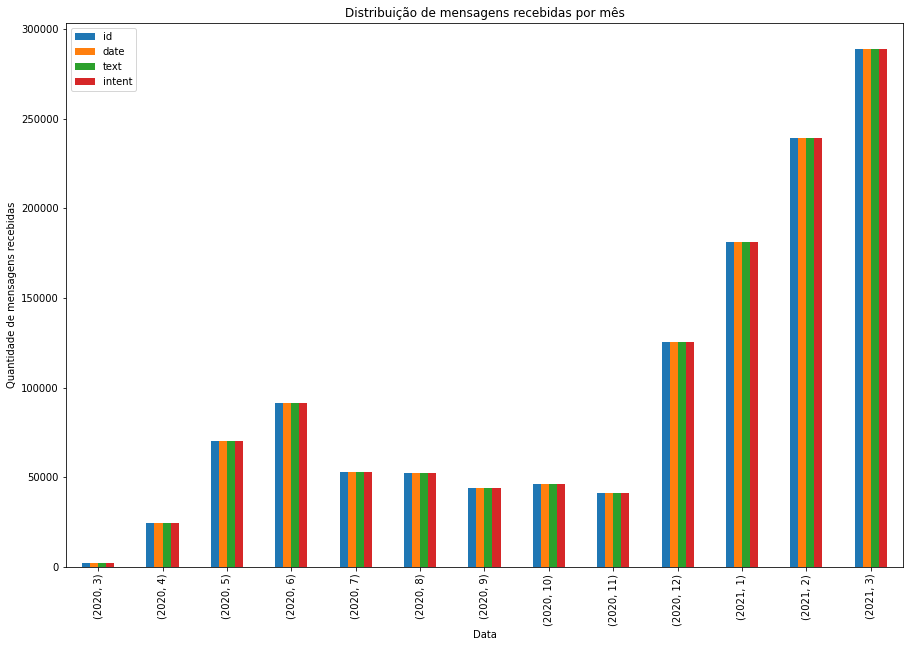

In [43]:
df.groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar",figsize=(15,10), title="Distribuição de mensagens recebidas por mês", xlabel="Data", ylabel="Quantidade de mensagens recebidas")

In [45]:
# Checando categorias das intenções classificadas pelo robô 
df.intent.nunique()

184

In [48]:
# São 184 intenções únicas, vamos checar as 20 primeiras
df.intent.value_counts()[:20]

greet                              940589
doubts                              77268
doubts_medical_screening            37238
doubts_city_hall                    15584
doubts_vaccine                      14398
doubts_coronavirus_confirmation     11696
doubts_vaccine_order                10896
doubts_symptoms                     10673
doubts_medicine                      7115
doubts_antibiotics                   7114
doubts_test_results                  6338
doubts_covid                         5242
menu_transmission                    4680
doubts_spread                        4531
menu_prevention                      4426
menu_treatment                       4424
complain_isolation                   4337
doubts_infected                      4143
doubts_how_where_cost_test           3761
doubts_risk_group                    3499
Name: intent, dtype: int64

In [51]:
sum(df.intent.value_counts().values[:20])/len(df)*100

93.49329963839318

### Ou seja, mais de 93% dos dados classificados poderiam ser representados pelas 20 categorias mais populares de intenção. Para simplificar nossas análises, limitaremos as classes presentes no dataset para estas 20. 

In [60]:
intents_populares = list(df.intent.value_counts().keys()[:20])

In [66]:
df = df[df['intent'].isin(intents_populares)]

In [67]:
df.shape

(1177952, 4)

## Com isso, podemos ter uma melhor visualizações das principais intenções:

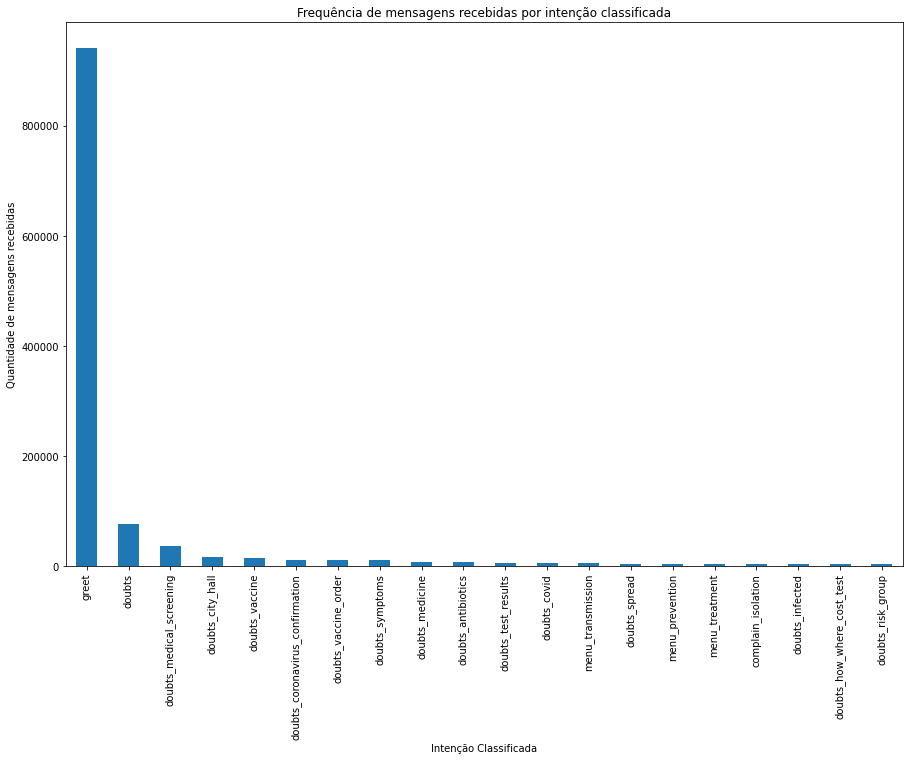

In [71]:
df["intent"].value_counts().plot(kind="bar",figsize=(15,10), title="Frequência de mensagens recebidas por intenção classificada", xlabel="Intenção Classificada", ylabel="Quantidade de mensagens recebidas")

## Notamos como o dataset está desbalanceado para a classe "greet". Podemos analisá-la com mais atenção para verificar se uma redução no número de casos não implicará em muita perda de informação 

In [72]:
greet_df = df[df["intent"] == "greet"]

In [73]:
greet_df.shape

(940589, 4)

In [74]:
#inicio dataset
greet_df.head(20)

id                          date text intent
0     5 2020-03-25 17:38:31.396850109   Oi  greet
2    17 2020-03-25 17:54:27.247100115   Oi  greet
5    33 2020-03-25 17:54:58.205969810   Oi  greet
7    41 2020-03-25 17:55:43.279109955   Oi  greet
8    49 2020-03-25 17:55:46.308470011   oi  greet
9    53 2020-03-25 17:55:48.087310076   Oi  greet
13   69 2020-03-25 17:58:17.967030048   Oi  greet
15   81 2020-03-25 20:42:02.916630030   Oi  greet
17   89 2020-03-25 20:43:05.408159971   Oi  greet
18   94 2020-03-25 20:43:05.619419813   Oi  greet
21  110 2020-03-25 17:38:31.396850109   Oi  greet
22  114 2020-03-25 17:54:27.247100115   Oi  greet
23  118 2020-03-25 17:54:58.205969810   Oi  greet
24  122 2020-03-25 17:55:43.279109955   Oi  greet
25  126 2020-03-25 17:55:48.087310076   Oi  greet
26  130 2020-03-25 17:58:17.967030048   Oi  greet
27  137 2020-03-26 15:49:34.606819868   Oi  greet
29  149 2020-03-26 15:54:18.985739946   Oi  greet
30  153 2020-03-26 15:54:36.787980080   Oi  greet
31  157 2020-03-26 15:54:49.757410049   Oi  greet

In [75]:
#final dataset
greet_df.tail(20)

id                          date text intent
1259977  11012663 2021-03-20 01:15:02.537899971   Oi  greet
1259978  11012674 2021-03-20 01:15:18.737210035   Oi  greet
1259979  11012681 2021-03-20 01:15:19.442380190   Oi  greet
1259980  11012692 2021-03-20 01:15:29.551669836   Oi  greet
1259981  11012703 2021-03-20 01:15:44.130949974   Oi  greet
1259982  11012717 2021-03-20 01:15:50.612750053   Oi  greet
1259983  11012725 2021-03-20 01:13:15.184809923   Oi  greet
1259984  11012735 2021-03-20 01:15:50.675610065   Oi  greet
1259985  11012742 2021-03-20 01:15:51.118249893   Oi  greet
1259986  11012749 2021-03-20 01:16:02.618750095   Oi  greet
1259987  11012756 2021-03-20 01:16:04.145190001   Oi  greet
1259988  11012767 2021-03-20 01:16:14.324190140   Oi  greet
1259989  11012778 2021-03-20 01:16:26.922549963   Oi  greet
1259990  11012789 2021-03-20 01:16:41.087939978   Oi  greet
1259991  11012800 2021-03-20 00:28:59.777280092   Oi  greet
1259992  11012807 2021-03-20 00:29:40.066390038   Oi  greet
1259996  11012835 2021-03-20 01:16:48.058519840   Oi  greet
1259997  11012846 2021-03-20 01:16:56.810960054   Oi  greet
1259998  11012853 2021-03-20 01:17:08.705539942   Oi  greet
1259999  11012864 2021-03-20 01:17:11.070960045   Oi  greet

### Parece que o termo "Oi" domina os exemplos encontrados na classe. Vamos contar sua frequência através de uma simples busca pelo termo

In [77]:
ois_count = len(greet_df[greet_df["text"]=="Oi"])
print("Total de Oi's: ", ois_count)
print("Proporção de Oi's na classe greet: ", ois_count/len(greet_df))

Total de Oi's:  922997
Proporção de Oi's na classe greet:  0.9812968257123994


### Assim, podemos descartar grande parte das mensagens repetidas Oi. Para este efeito, vamos equilibrar a classe greet com a segunda mais popular "doubts", que conta com 77268 exemplos

In [78]:
# df sem classe greet:
df_no_greet = df[df["intent"] != "greet"]

In [79]:
df_no_greet.shape

(237363, 4)

In [85]:
greet_df_no_oi = greet_df[greet_df["text"]!="Oi"]

In [87]:
greet_df_oi = greet_df[greet_df["text"]=="Oi"]

In [91]:
77268 - len(greet_df_no_oi)

59676

In [93]:
greet_df_oi.shape

(922997, 4)

In [94]:
# Selecionando 59676 mensagens randomicamente:
greet_df_oi = greet_df_oi.sample(n=59676)

In [95]:
greet_df_oi.shape

(59676, 4)

### Montando novamente o dataset com as mensagens de diferentes classes, agora menos desbalanceadas

In [97]:
df.shape

(1177952, 4)

In [101]:
df = df_no_greet.append([greet_df_oi,greet_df_no_oi], ignore_index=True).sort_values(by=['date'],ignore_index=True)

## Verificações anteriores atualizadas

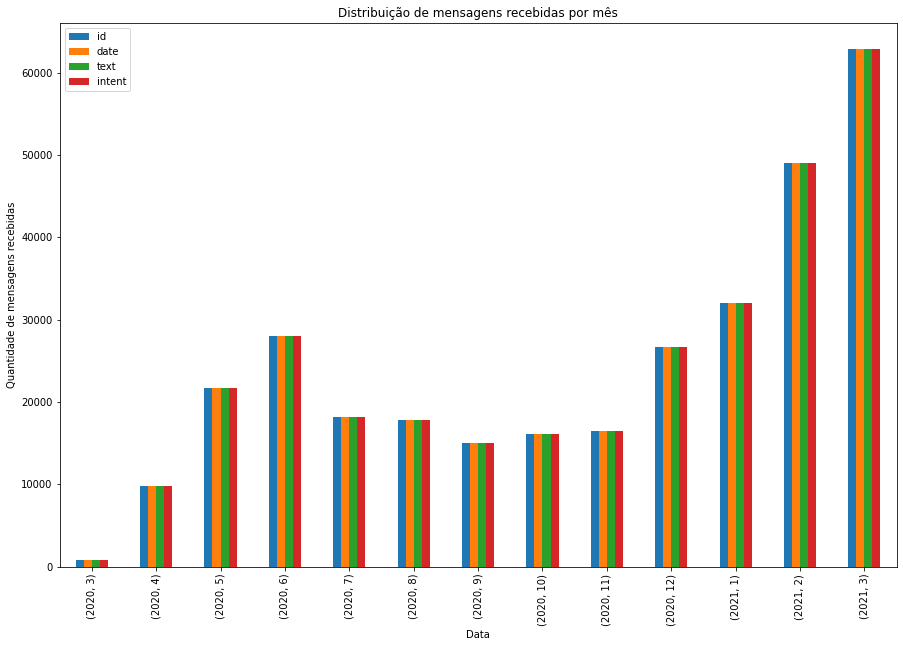

In [103]:
df.groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar",figsize=(15,10), title="Distribuição de mensagens recebidas por mês", xlabel="Data", ylabel="Quantidade de mensagens recebidas")

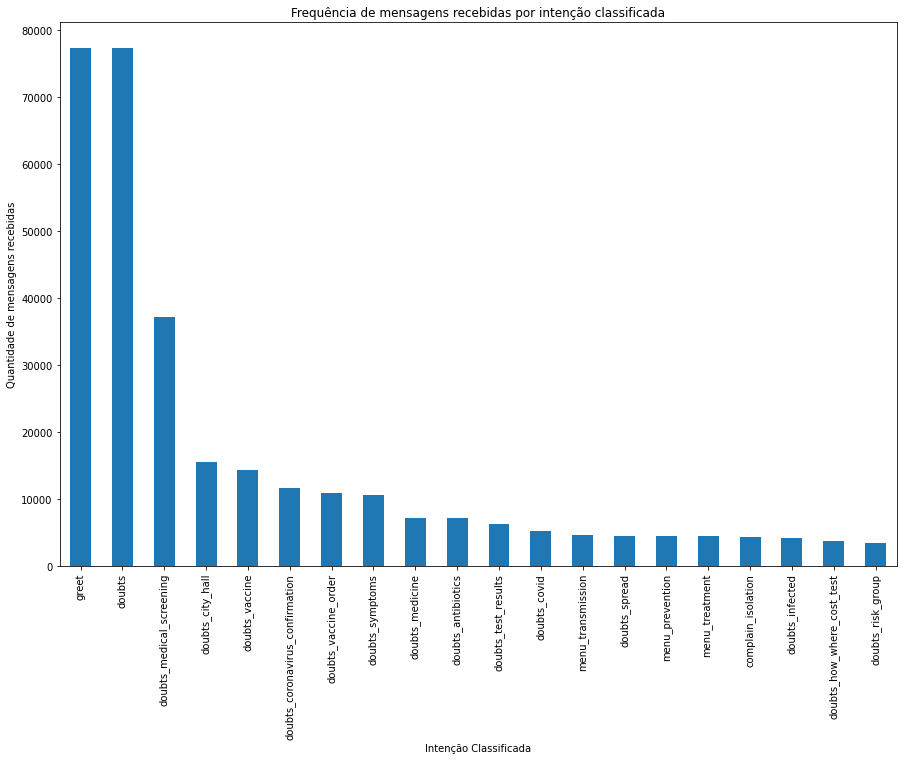

In [104]:
df["intent"].value_counts().plot(kind="bar",figsize=(15,10), title="Frequência de mensagens recebidas por intenção classificada", xlabel="Intenção Classificada", ylabel="Quantidade de mensagens recebidas")

In [105]:
#checkpoint
df.to_csv('dataset_balanced.csv', header=True, index=False)

# Parte II: Tratamentos de texto

In [109]:
import numpy as np
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

## Aplicando tokenização na coluna *text*

In [110]:
df['tokenized'] = df['text'].apply(word_tokenize)
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized  
0                       [Oi]  
1           [Tirar, dúvidas]  
2           [Tirar, dúvidas]  
3  [Como, é, transmitido, ?]  
4                       [oi]

## Padronizando texto em minúsculo

In [111]:
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  
0                       [Oi]                       [oi]  
1           [Tirar, dúvidas]           [tirar, dúvidas]  
2           [Tirar, dúvidas]           [tirar, dúvidas]  
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]  
4                       [oi]                       [oi]

## Retirando puntuação - menos '?', pois é importante para caracterizar dúvidas nas mensagens

In [115]:
punc = string.punctuation.replace('?','')

In [116]:
punc

'!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

In [117]:
df['no_punc'] = df['lower'].apply(lambda x: [word for word in x if word not in punc])
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  \
0                       [Oi]                       [oi]   
1           [Tirar, dúvidas]           [tirar, dúvidas]   
2           [Tirar, dúvidas]           [tirar, dúvidas]   
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]   
4                       [oi]                       [oi]   

                     no_punc  
0                       [oi]  
1           [tirar, dúvidas]  
2           [tirar, dúvidas]  
3  [como, é, transmitido, ?]  
4                       [oi]

## Retirando acentuação

In [120]:
import unicodedata
import re

"""
A remoção de acentos foi baseada em uma resposta no Stack Overflow.
http://stackoverflow.com/a/517974/3464573
"""

def removerAcentosECaracteresEspeciais(palavra):

    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9? \\\]', '', palavraSemAcento)

In [122]:
df['no_punc_accen'] = df['no_punc'].apply(lambda x: [removerAcentosECaracteresEspeciais(word) for word in x])
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  \
0                       [Oi]                       [oi]   
1           [Tirar, dúvidas]           [tirar, dúvidas]   
2           [Tirar, dúvidas]           [tirar, dúvidas]   
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]   
4                       [oi]                       [oi]   

                     no_punc              no_punc_accen  
0                       [oi]                       [oi]  
1           [tirar, dúvidas]           [tirar, duvidas]  
2           [tirar, dúvidas]           [tirar, duvidas]  
3  [como, é, transmitido, ?]  [como, e, transmitido, ?]  
4                       [oi]                       [oi]

## Retirando stop words do português

In [123]:
stop_words = set(stopwords.words('portuguese'))
df['stopwords_removed'] = df['no_punc_accen'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  \
0                       [Oi]                       [oi]   
1           [Tirar, dúvidas]           [tirar, dúvidas]   
2           [Tirar, dúvidas]           [tirar, dúvidas]   
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]   
4                       [oi]                       [oi]   

                     no_punc              no_punc_accen stopwords_removed  
0                       [oi]                       [oi]              [oi]  
1           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]  
2           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]  
3  [como, é, transmitido, ?]  [como, e, transmitido, ?]  [transmitido, ?]  
4                       [oi]                       [oi]              [oi]

## Aplicando POS tagging
utilizando material disponibilizado em https://github.com/inoueMashuu/POS-tagger-portuguese-nltk, pos-tagger treinado a partir do corpus Mac-Morpho, em português e presente no NLTK.

In [124]:
import joblib

tagger = joblib.load('POS_tagger_brill.pkl')

In [158]:
# Exemplo
tagger.tag(word_tokenize("estaremos"))[0]

('estaremos', 'VAUX')

In [156]:
df['pos_tags'] = df['stopwords_removed'].apply(lambda x: [tagger.tag(word_tokenize(word))[0] for word in x if len(word)>0])


In [157]:
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  \
0                       [Oi]                       [oi]   
1           [Tirar, dúvidas]           [tirar, dúvidas]   
2           [Tirar, dúvidas]           [tirar, dúvidas]   
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]   
4                       [oi]                       [oi]   

                     no_punc              no_punc_accen stopwords_removed  \
0                       [oi]                       [oi]              [oi]   
1           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]   
2           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]   
3  [como, é, transmitido, ?]  [como, e, transmitido, ?]  [transmitido, ?]   
4                       [oi]                       [oi]              [oi]   

                       pos_tags  
0                     [(oi, N)]  
1    [(tirar, V), (duvidas, N)]  
2    [(tirar, V), (duvidas, N)]  
3  [(transmitido, PCP), (?, ?)]  
4                     [(oi, N)]

In [296]:
tags = df['pos_tags'].apply(lambda x: [tupl[1] for tupl in x])

In [300]:
list(tags)[:10]

[['N'],
 ['V', 'N'],
 ['V', 'N'],
 ['PCP', '?'],
 ['N'],
 ['V', 'N'],
 ['V', 'N'],
 ['PCP', '?'],
 ['V', 'N'],
 ['N']]

In [304]:
tags = [item for sublist in list(tags) for item in sublist]

In [305]:
tags[:10]

['N', 'V', 'N', 'V', 'N', 'PCP', '?', 'N', 'V', 'N']

In [308]:
tags_df = pd.DataFrame(data=tags, columns=['tags'])

In [312]:
tags_df['tags'].nunique()

31

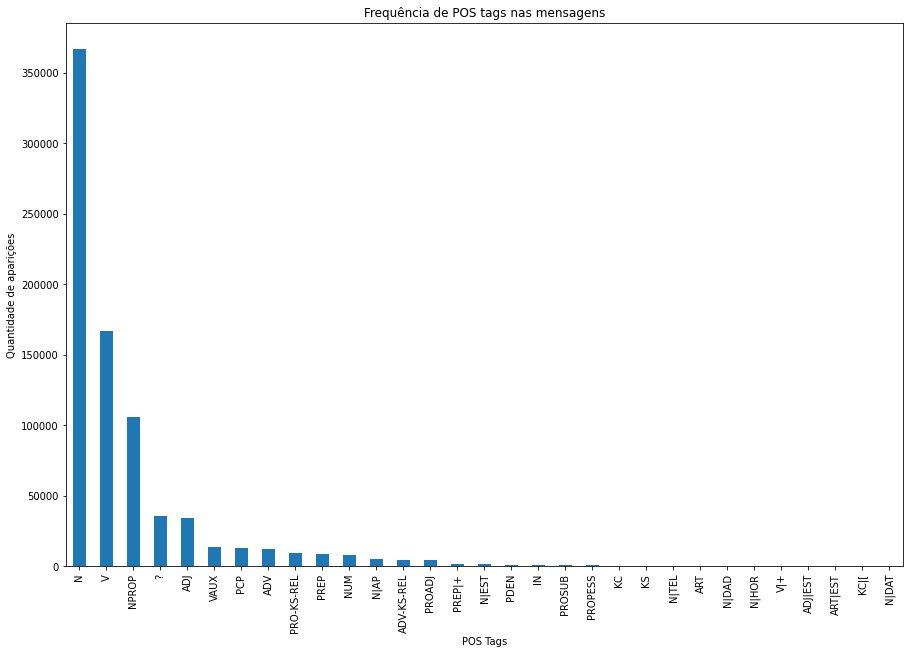

In [313]:
tags_df["tags"].value_counts().plot(kind="bar",figsize=(15,10), title="Frequência de POS tags nas mensagens", xlabel="POS Tags", ylabel="Quantidade de aparições")

## Aplicando stemming com RSLP Portuguese Stemmer 

In [160]:
stemmer = nltk.stem.RSLPStemmer()

In [170]:
# Exemplo
stemmer.stem("transmissão")

'transmiss'

In [172]:
df['stemmed'] = df['stopwords_removed'].apply(lambda x: [stemmer.stem(word) for word in x if len(word)>0])
df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  \
0                       [Oi]                       [oi]   
1           [Tirar, dúvidas]           [tirar, dúvidas]   
2           [Tirar, dúvidas]           [tirar, dúvidas]   
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]   
4                       [oi]                       [oi]   

                     no_punc              no_punc_accen stopwords_removed  \
0                       [oi]                       [oi]              [oi]   
1           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]   
2           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]   
3  [como, é, transmitido, ?]  [como, e, transmitido, ?]  [transmitido, ?]   
4                       [oi]                       [oi]              [oi]   

                       pos_tags        stemmed  
0                     [(oi, N)]           [oi]  
1    [(tirar, V), (duvidas, N)]   [tir, duvid]  
2    [(tirar, V), (duvidas, N)]   [tir, duvid]  
3  [(transmitido, PCP), (?, ?)]  [transmit, ?]  
4                     [(oi, N)]           [oi]

In [173]:
# checkpoint
df.to_csv('dataset_processed.csv', header=True, index=False)

# Parte III: Análise Exploratória dos Dados 

In [185]:
import pickle
import pyLDAvis.sklearn
from collections import Counter
#from textblob import TextBlob
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns

## Contando número de palavras e tamanho da mensagem

In [187]:
df['stemmed_str'] = [' '.join(map(str,l)) for l in df['stemmed']]
df['stopwords_str'] = [' '.join(map(str,l)) for l in df['stopwords_removed']]

df.head()

id                          date                 text         intent  \
0   5 2020-03-25 17:38:31.396850109                   Oi          greet   
1  13 2020-03-25 17:38:32.919719934        Tirar dúvidas         doubts   
2  25 2020-03-25 17:54:30.741859913        Tirar dúvidas         doubts   
3  29 2020-03-25 17:54:34.778069973  Como é transmitido?  doubts_spread   
4  49 2020-03-25 17:55:46.308470011                   oi          greet   

                   tokenized                      lower  \
0                       [Oi]                       [oi]   
1           [Tirar, dúvidas]           [tirar, dúvidas]   
2           [Tirar, dúvidas]           [tirar, dúvidas]   
3  [Como, é, transmitido, ?]  [como, é, transmitido, ?]   
4                       [oi]                       [oi]   

                     no_punc              no_punc_accen stopwords_removed  \
0                       [oi]                       [oi]              [oi]   
1           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]   
2           [tirar, dúvidas]           [tirar, duvidas]  [tirar, duvidas]   
3  [como, é, transmitido, ?]  [como, e, transmitido, ?]  [transmitido, ?]   
4                       [oi]                       [oi]              [oi]   

                       pos_tags        stemmed stemmed_str  stopwords_str  
0                     [(oi, N)]           [oi]          oi             oi  
1    [(tirar, V), (duvidas, N)]   [tir, duvid]   tir duvid  tirar duvidas  
2    [(tirar, V), (duvidas, N)]   [tir, duvid]   tir duvid  tirar duvidas  
3  [(transmitido, PCP), (?, ?)]  [transmit, ?]  transmit ?  transmitido ?  
4                     [(oi, N)]           [oi]          oi             oi

In [188]:
header_eda = ['date', 'intent', 'stopwords_removed','stemmed','stemmed_str','stopwords_str']

In [189]:
df_eda = df[header_eda]

In [190]:
df_eda.head()

date         intent stopwords_removed  \
0 2020-03-25 17:38:31.396850109          greet              [oi]   
1 2020-03-25 17:38:32.919719934         doubts  [tirar, duvidas]   
2 2020-03-25 17:54:30.741859913         doubts  [tirar, duvidas]   
3 2020-03-25 17:54:34.778069973  doubts_spread  [transmitido, ?]   
4 2020-03-25 17:55:46.308470011          greet              [oi]   

         stemmed stemmed_str  stopwords_str  
0           [oi]          oi             oi  
1   [tir, duvid]   tir duvid  tirar duvidas  
2   [tir, duvid]   tir duvid  tirar duvidas  
3  [transmit, ?]  transmit ?  transmitido ?  
4           [oi]          oi             oi

In [191]:
df_eda['word_count'] = df['stemmed'].apply(lambda x: len(str(x).split()))
df_eda['message_len'] = df['stemmed_str'].astype(str).apply(len)

In [192]:
df_eda.head()

date         intent stopwords_removed  \
0 2020-03-25 17:38:31.396850109          greet              [oi]   
1 2020-03-25 17:38:32.919719934         doubts  [tirar, duvidas]   
2 2020-03-25 17:54:30.741859913         doubts  [tirar, duvidas]   
3 2020-03-25 17:54:34.778069973  doubts_spread  [transmitido, ?]   
4 2020-03-25 17:55:46.308470011          greet              [oi]   

         stemmed stemmed_str  stopwords_str  word_count  message_len  
0           [oi]          oi             oi           1            2  
1   [tir, duvid]   tir duvid  tirar duvidas           2            9  
2   [tir, duvid]   tir duvid  tirar duvidas           2            9  
3  [transmit, ?]  transmit ?  transmitido ?           2           10  
4           [oi]          oi             oi           1            2

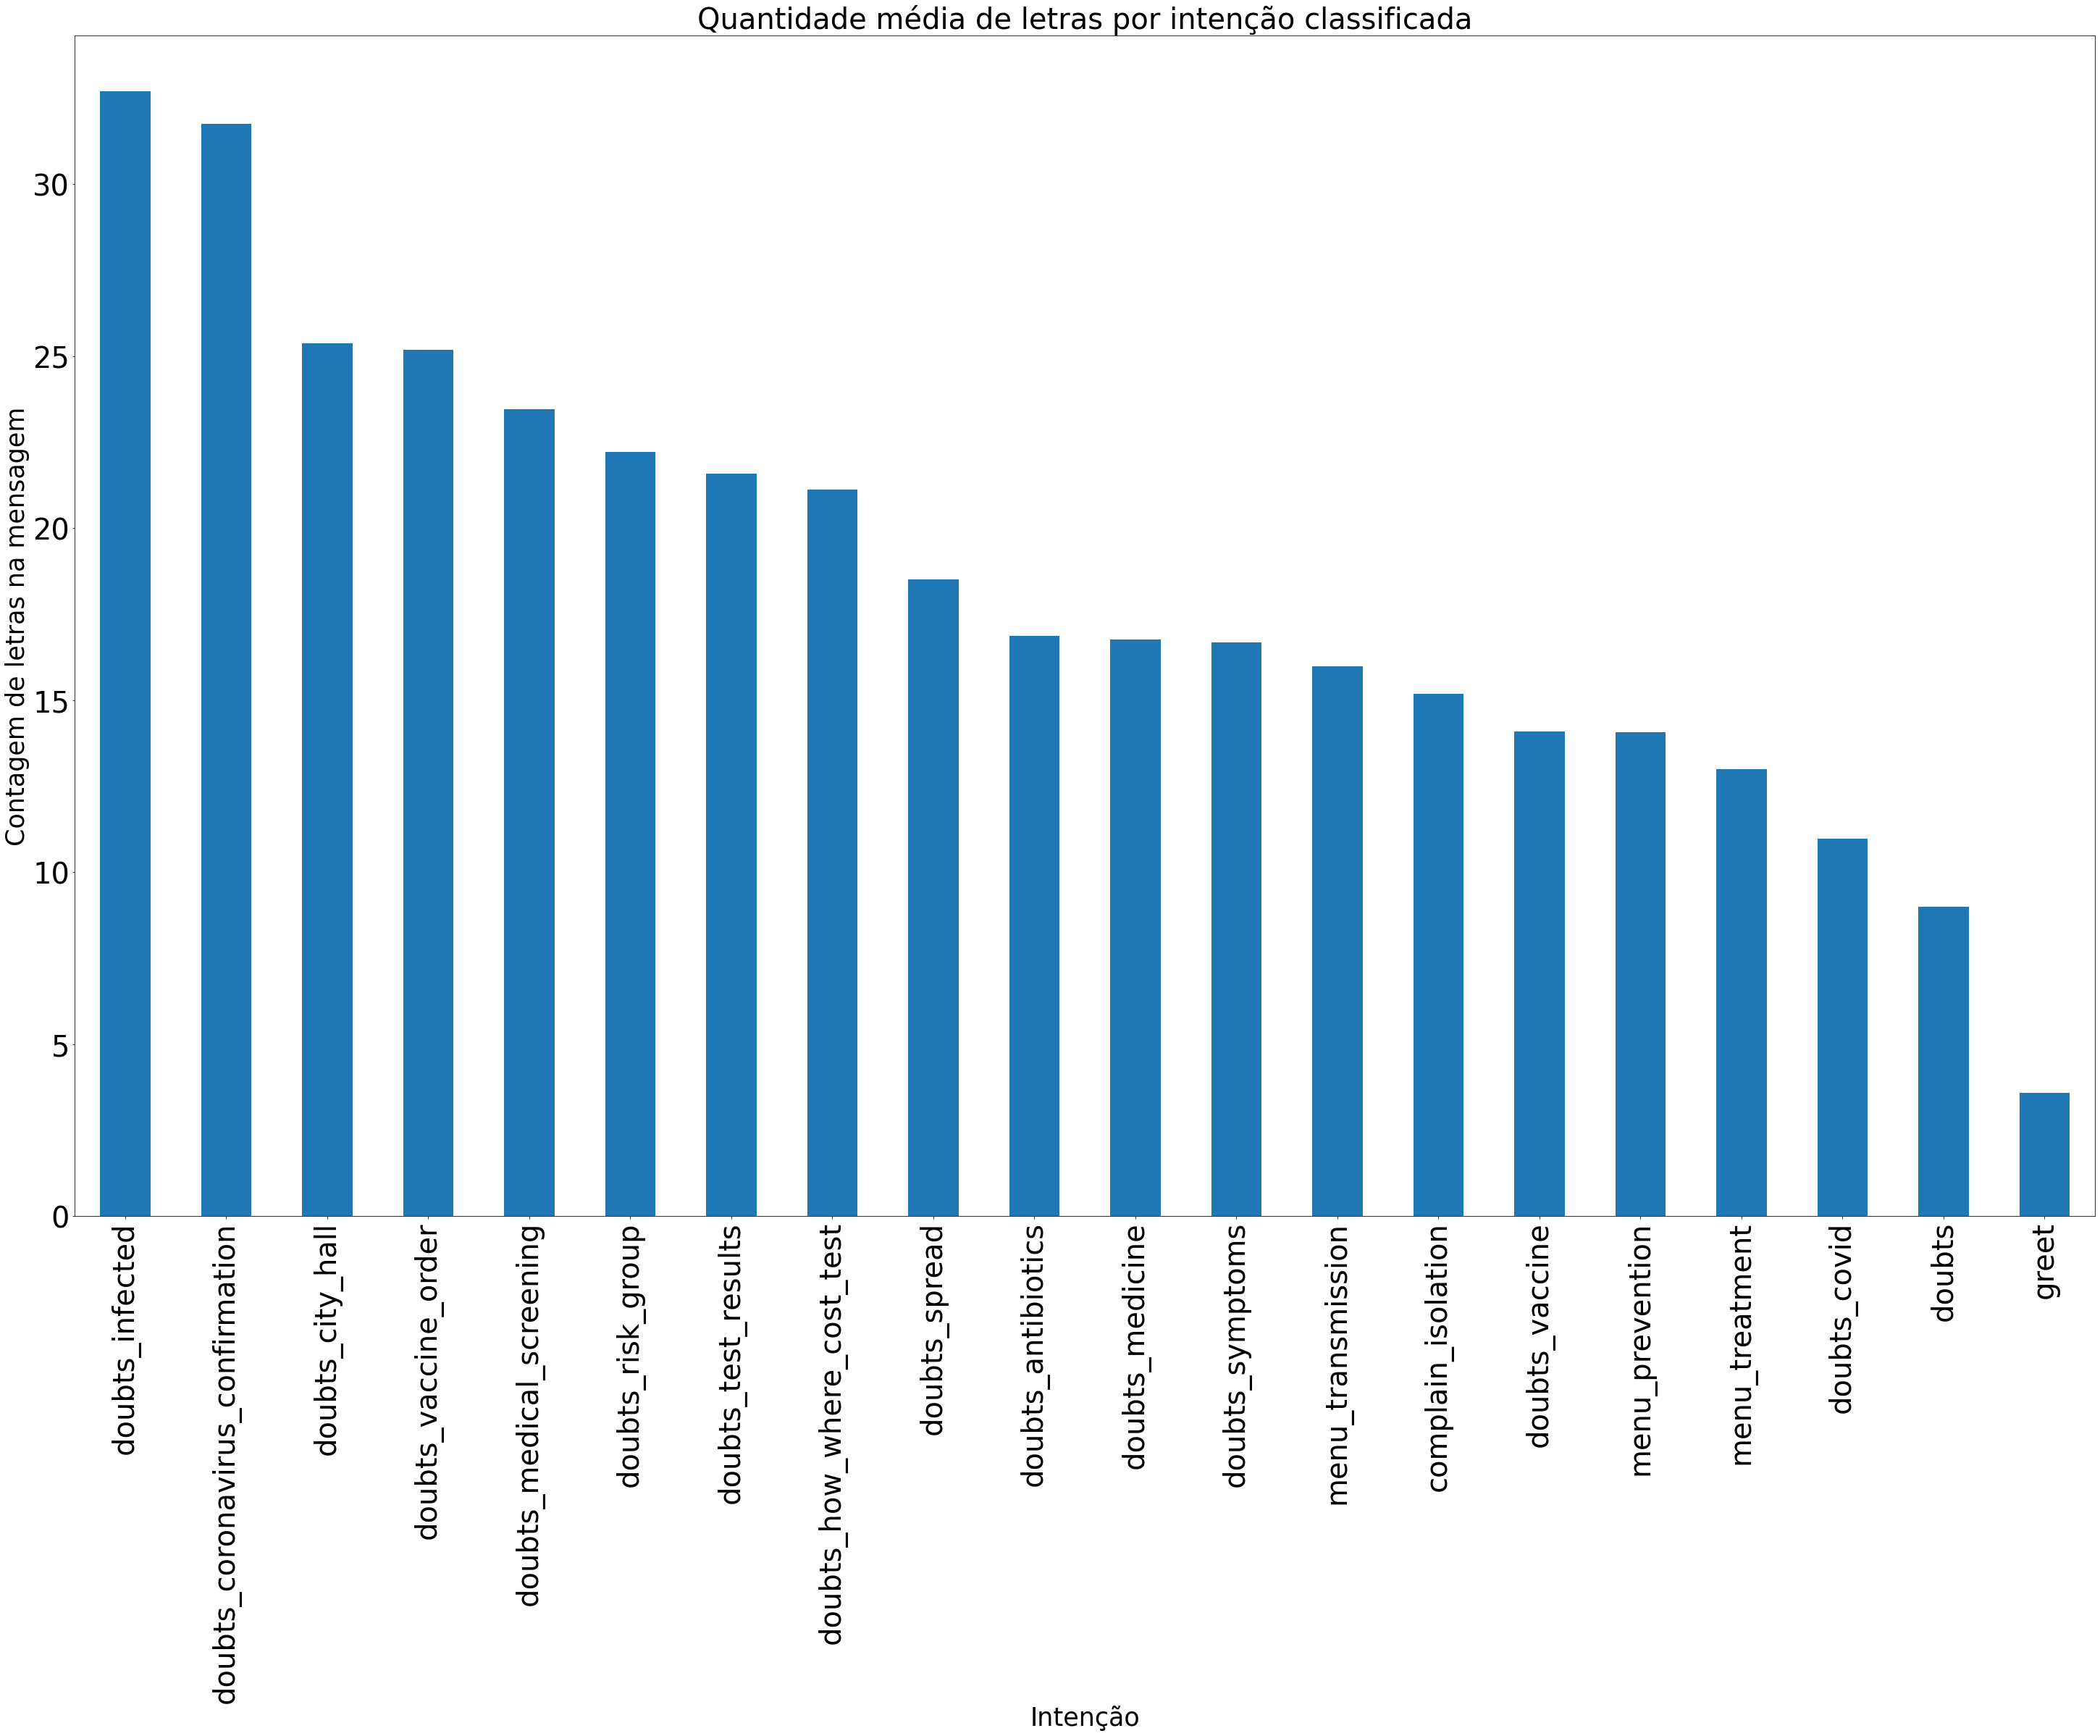

In [195]:
letter_avg = df_eda.groupby('intent')['message_len'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(50,30))
plt.xlabel('Intenção', fontsize=35)
plt.ylabel('Contagem de letras na mensagem', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Quantidade média de letras nas mensagens por intenção classificada', fontsize=40)
plt.show()

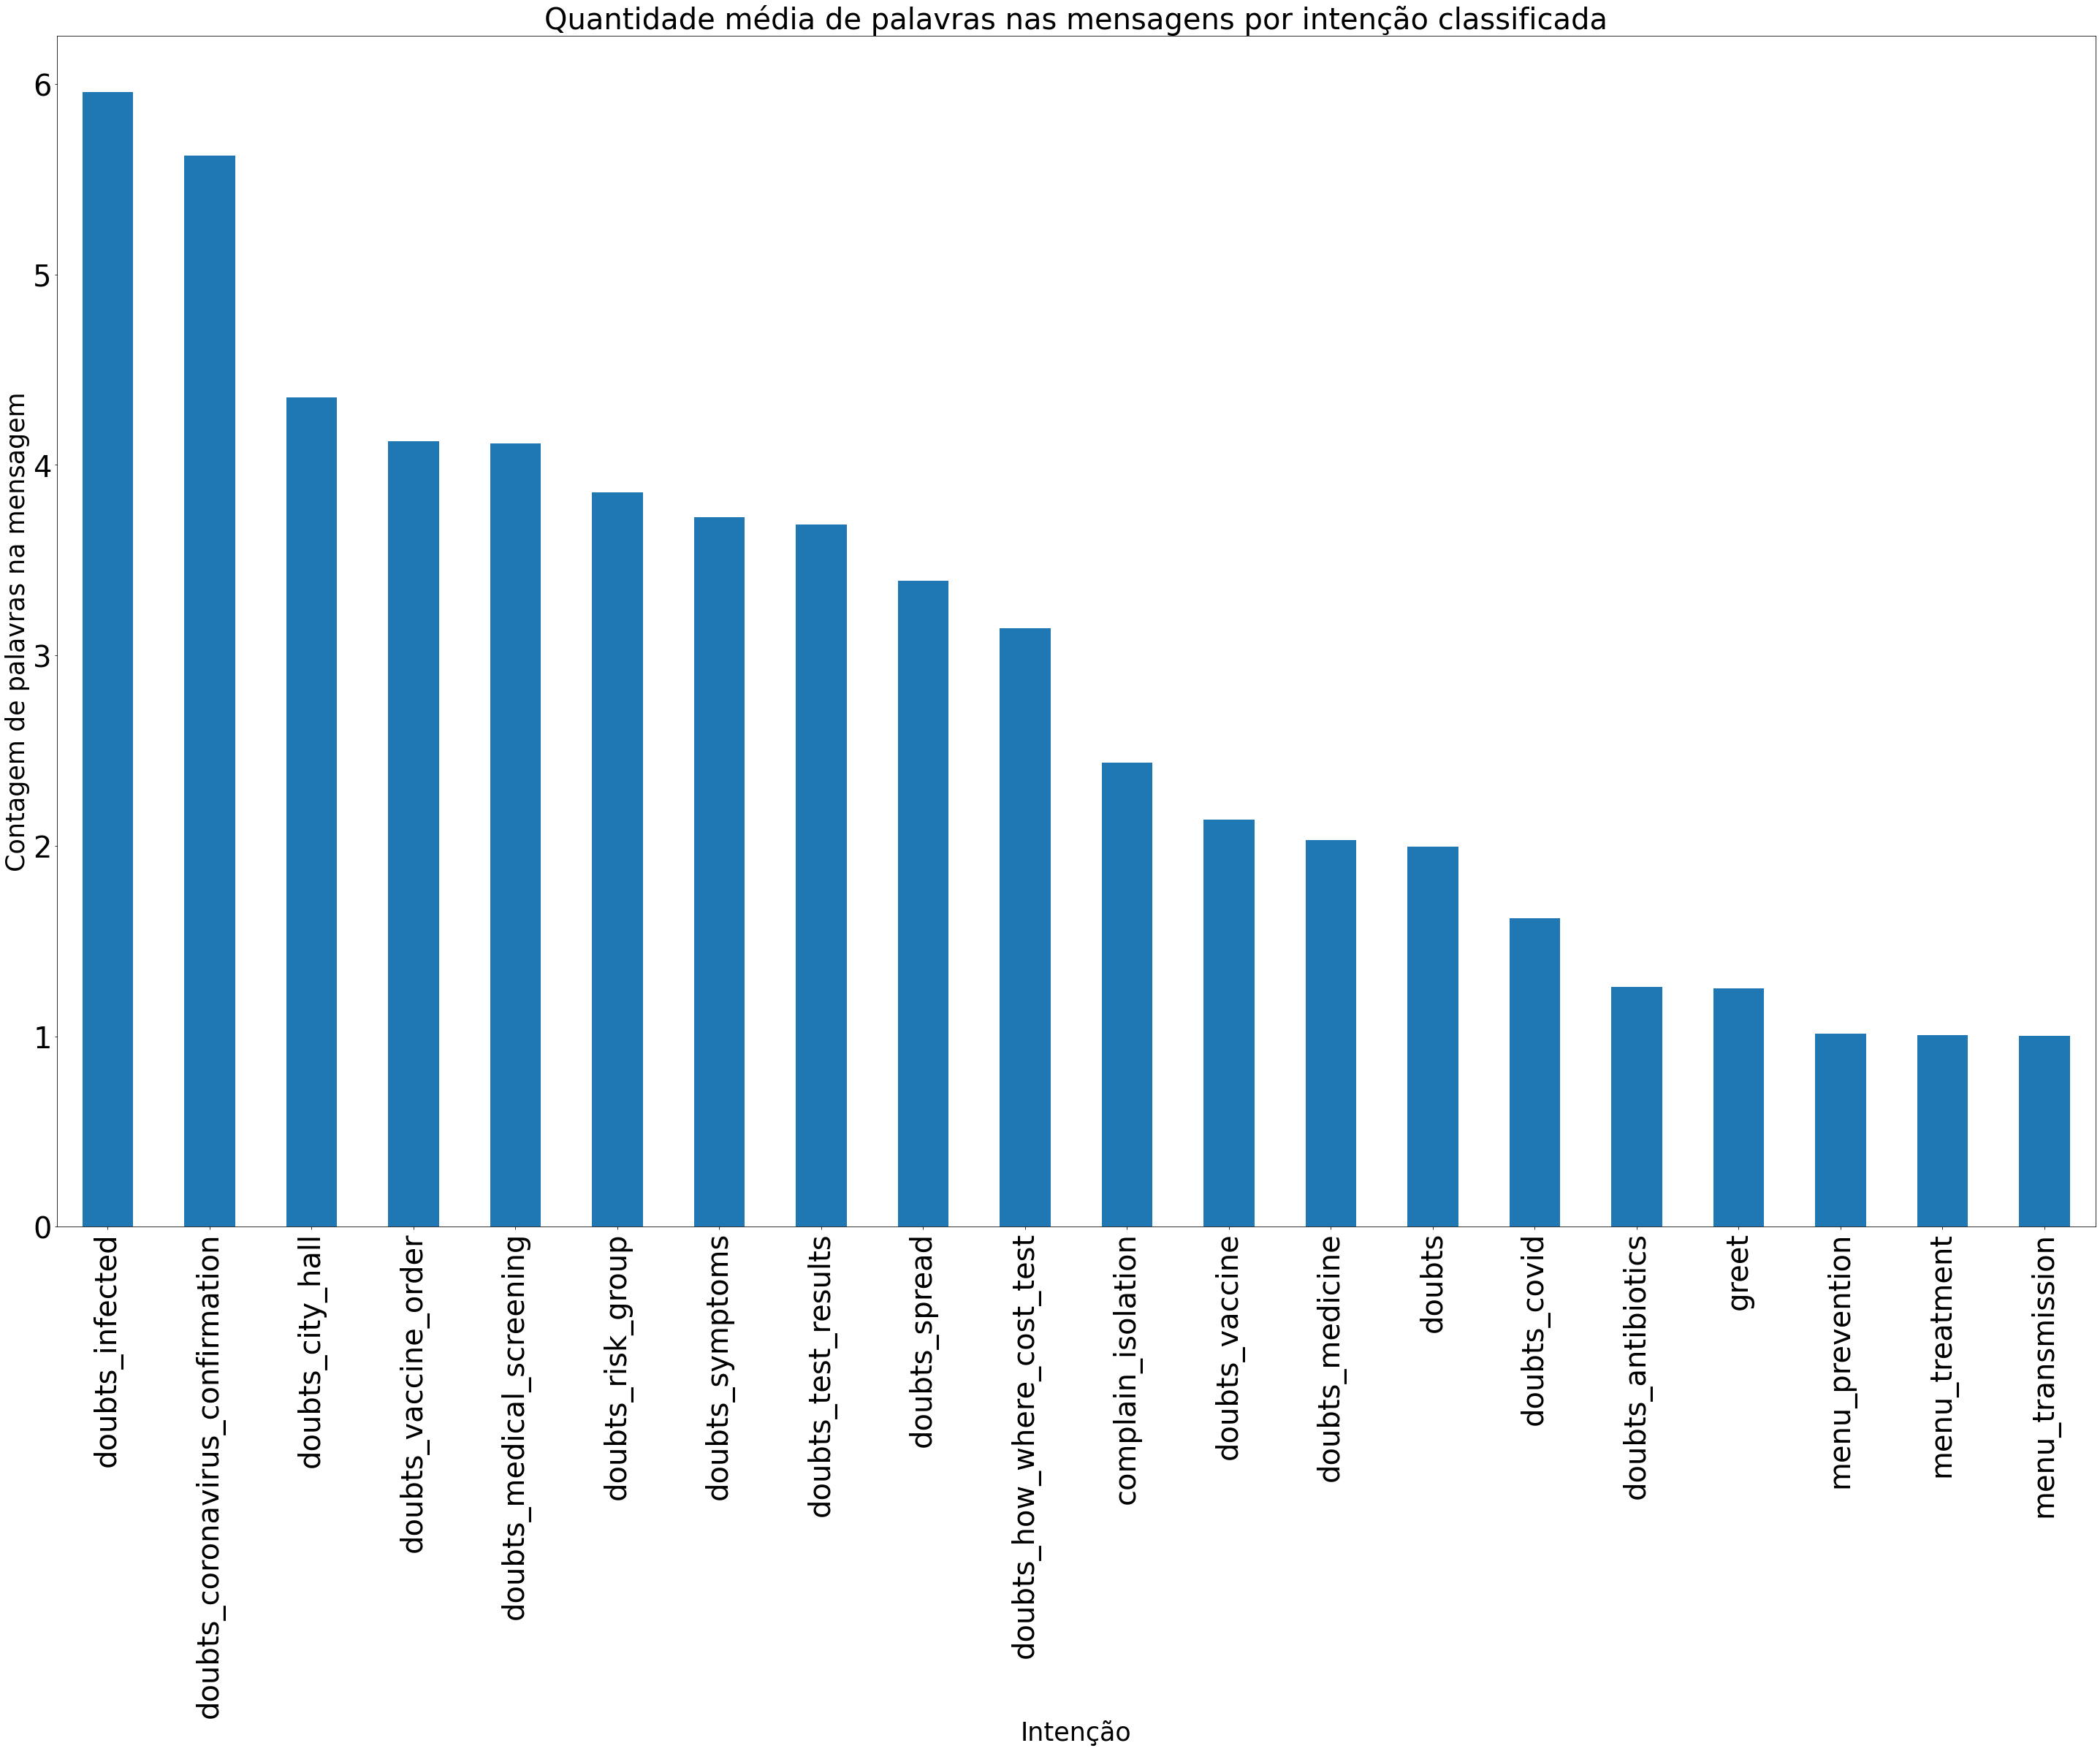

In [196]:
word_avg = df_eda.groupby('intent')['word_count'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(50,30))
plt.xlabel('Intenção', fontsize=35)
plt.ylabel('Contagem de palavras na mensagem', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Quantidade média de palavras nas mensagens por intenção classificada', fontsize=40)
plt.show()

## Análise por frequência de termos

In [209]:
lista_intents = list(df_eda['intent'].unique())

In [212]:
lista_intents = [elem.replace('_','') for elem in lista_intents]

In [199]:
words = df_eda['stopwords_removed']
allwords = []
for wordlist in words:
    allwords += wordlist

In [263]:
allwords = [x for x in allwords if x not in lista_intents]

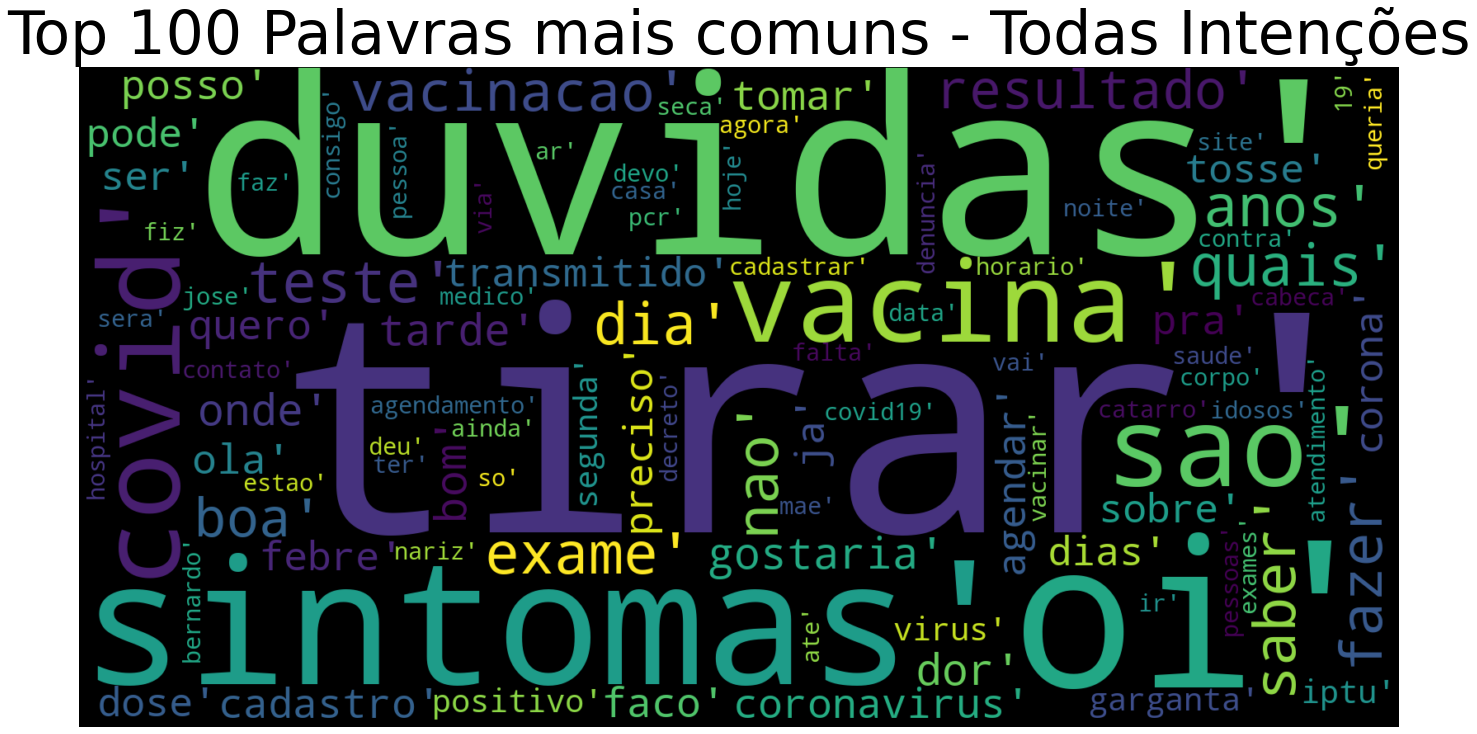

In [265]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='black', stopwords=lista_intents).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Palavras mais comuns - Todas Intenções', fontsize=60)
plt.tight_layout(pad=0)
plt.show()

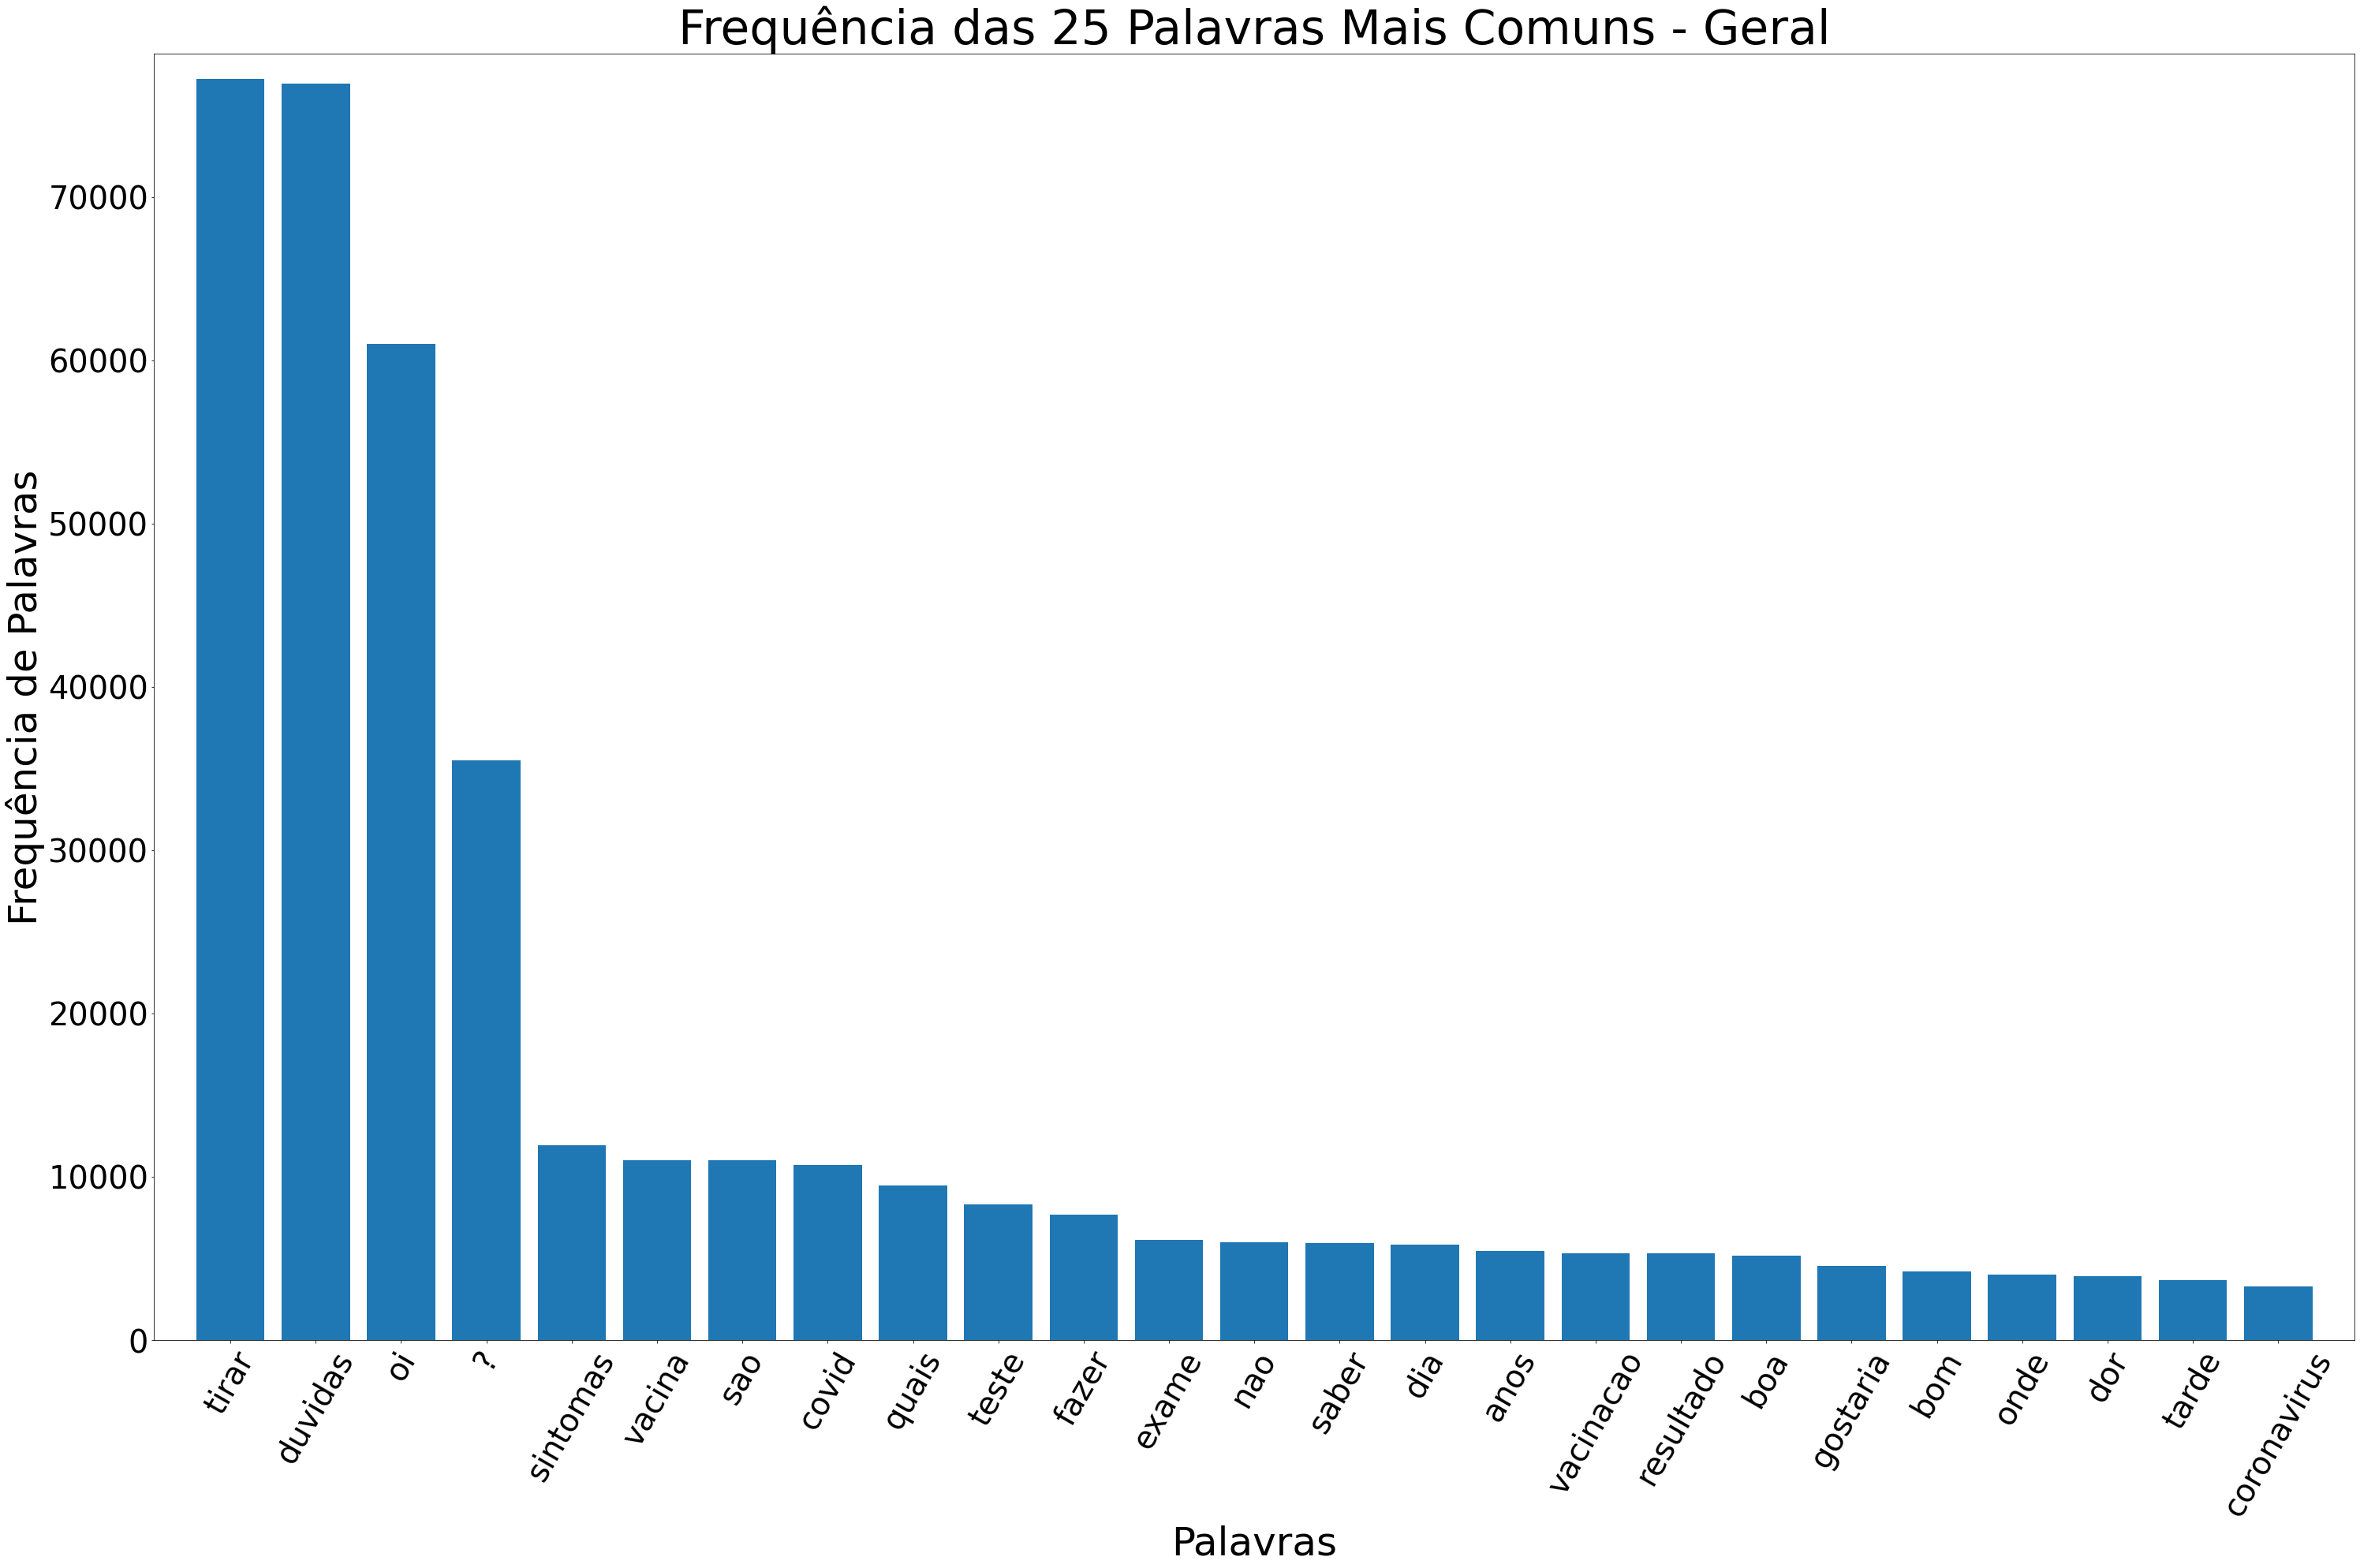

In [268]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Palavras', fontsize=50)
plt.ylabel('Frequência de Palavras', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequência das 25 Palavras Mais Comuns - Geral', fontsize=60)
plt.show()

## Palavras mais comuns para as quatro intenções mais frequentes

## Greet

In [274]:
words_greet = df_eda['stopwords_removed'][df_eda['intent']=='greet']
allwords_greet = []
for wordlist in words_greet:
    allwords_greet += wordlist

allwords_greet = [x for x in allwords_greet if x not in lista_intents]

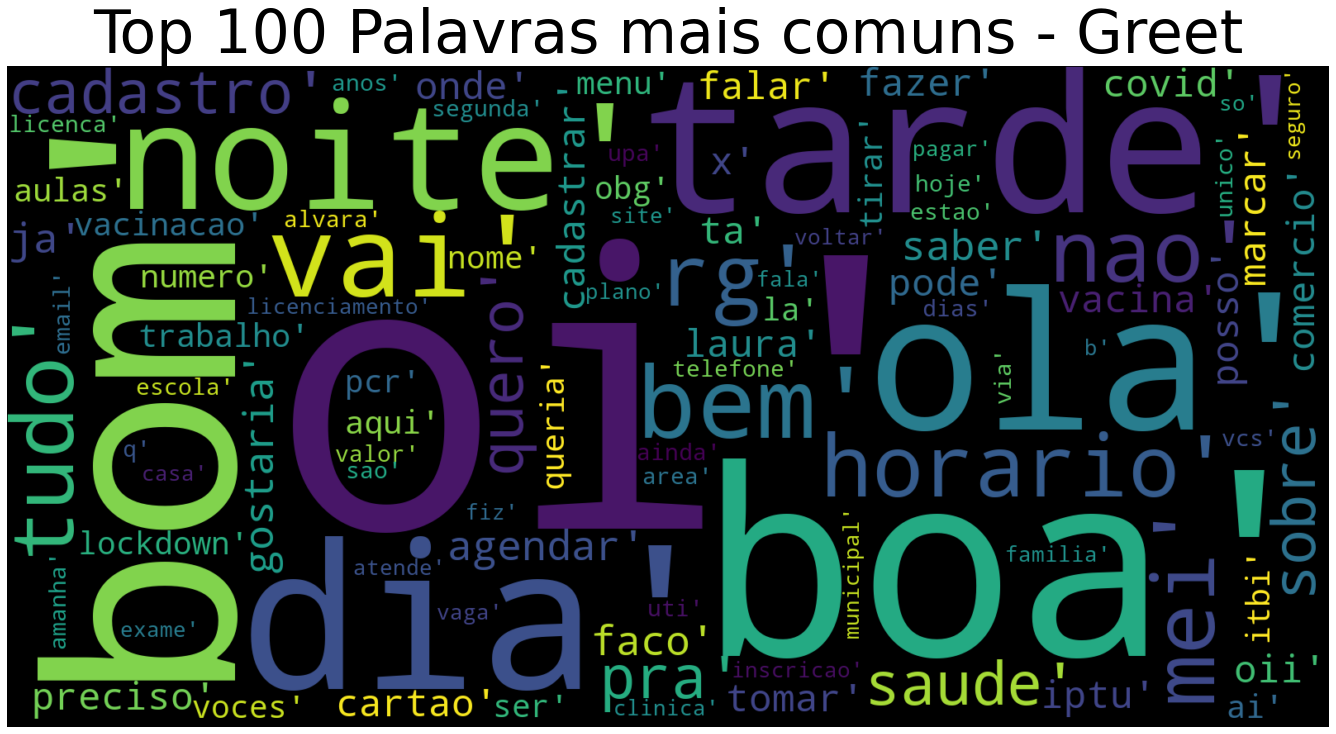

In [275]:
mostcommon_greet = FreqDist(allwords_greet).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='black', stopwords=lista_intents).generate(str(mostcommon_greet))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Palavras mais comuns - Greet', fontsize=60)
plt.tight_layout(pad=0)
plt.show()

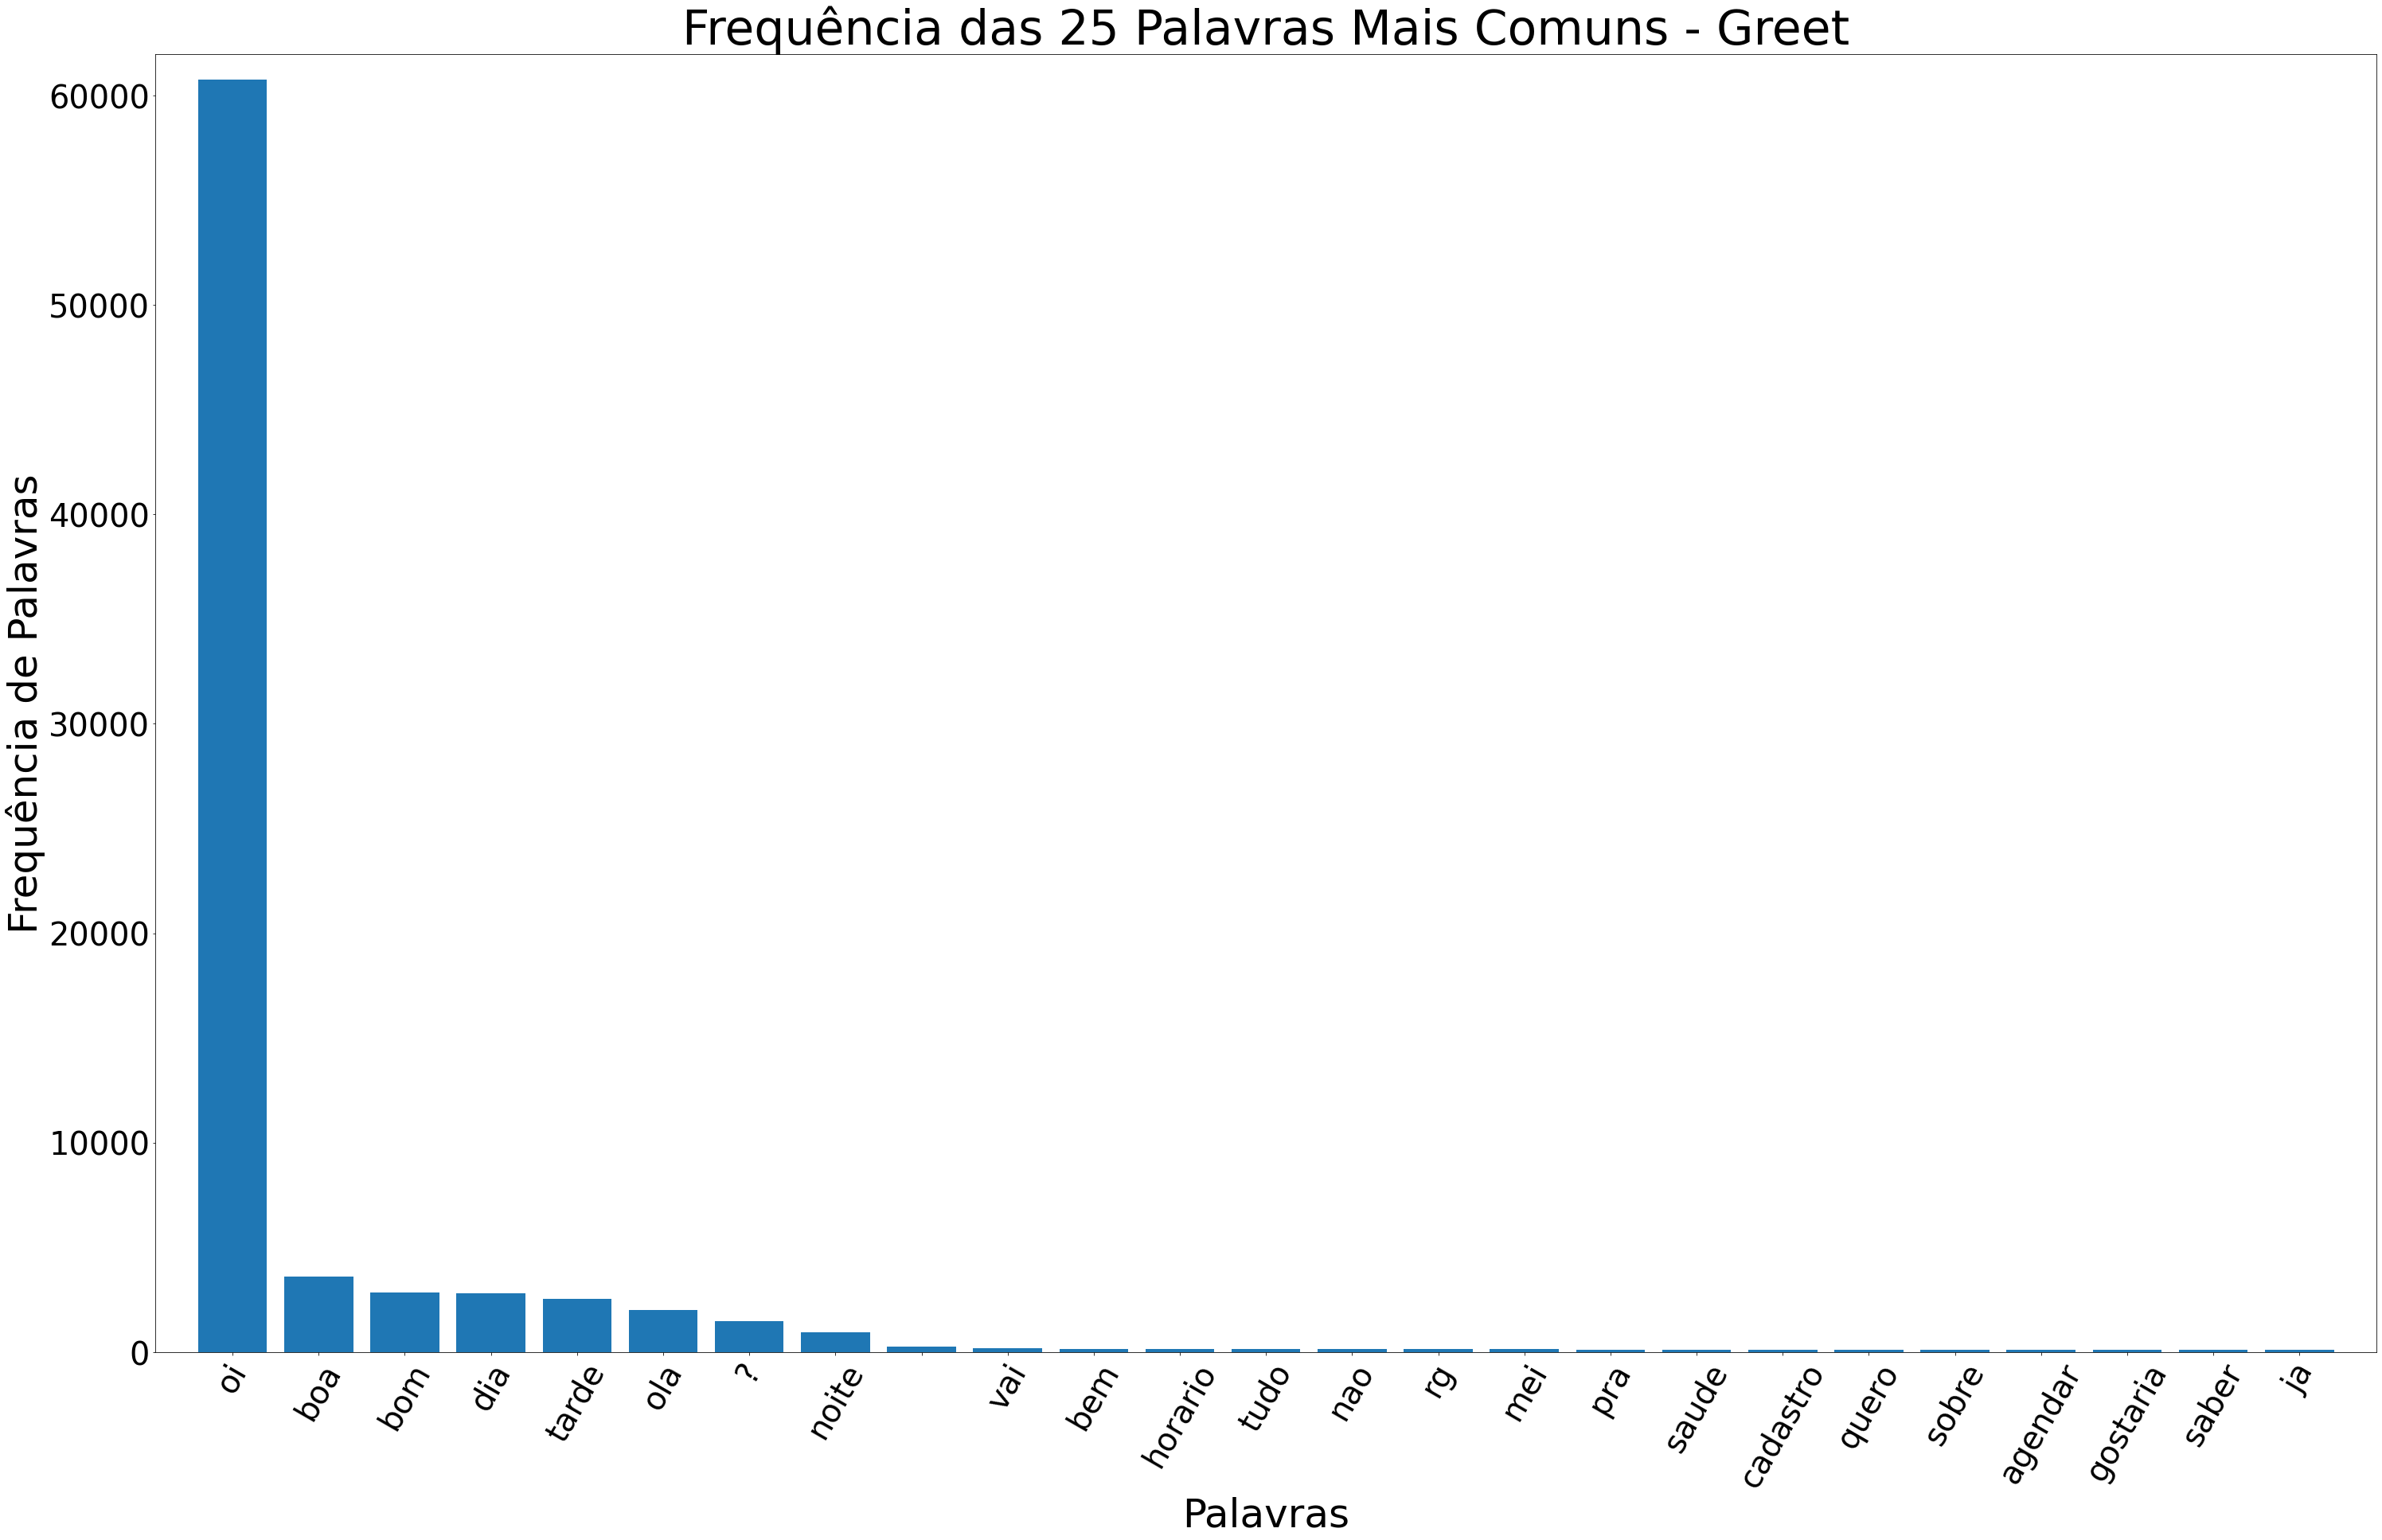

In [276]:
mostcommon_small_greet = FreqDist(allwords_greet).most_common(25)
x, y = zip(*mostcommon_small_greet)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Palavras', fontsize=50)
plt.ylabel('Frequência de Palavras', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequência das 25 Palavras Mais Comuns - Greet', fontsize=60)
plt.show()

## Doubts

In [277]:
words_doubts = df_eda['stopwords_removed'][df_eda['intent']=='doubts']
allwords_doubts = []
for wordlist in words_doubts:
    allwords_doubts += wordlist

allwords_doubts = [x for x in allwords_doubts if x not in lista_intents]

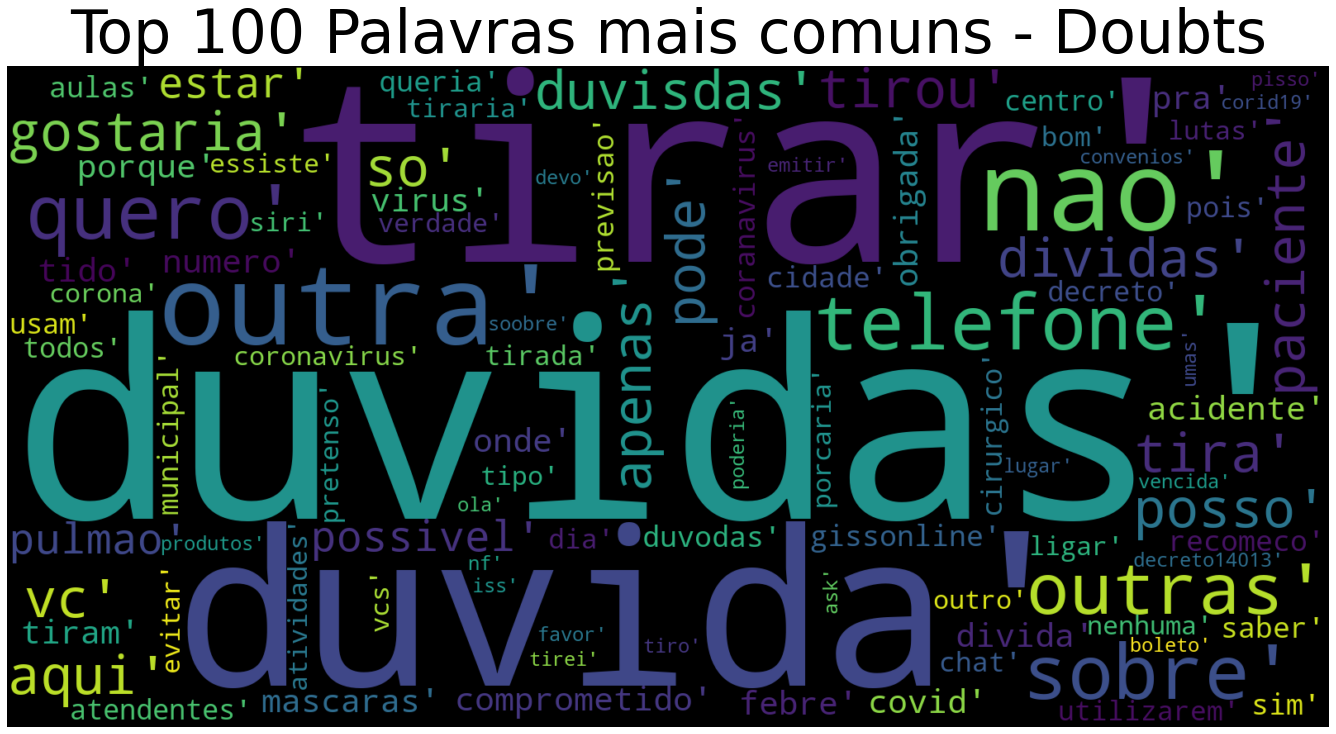

In [278]:
mostcommon_doubts = FreqDist(allwords_doubts).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='black', stopwords=lista_intents).generate(str(mostcommon_doubts))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Palavras mais comuns - Doubts', fontsize=60)
plt.tight_layout(pad=0)
plt.show()

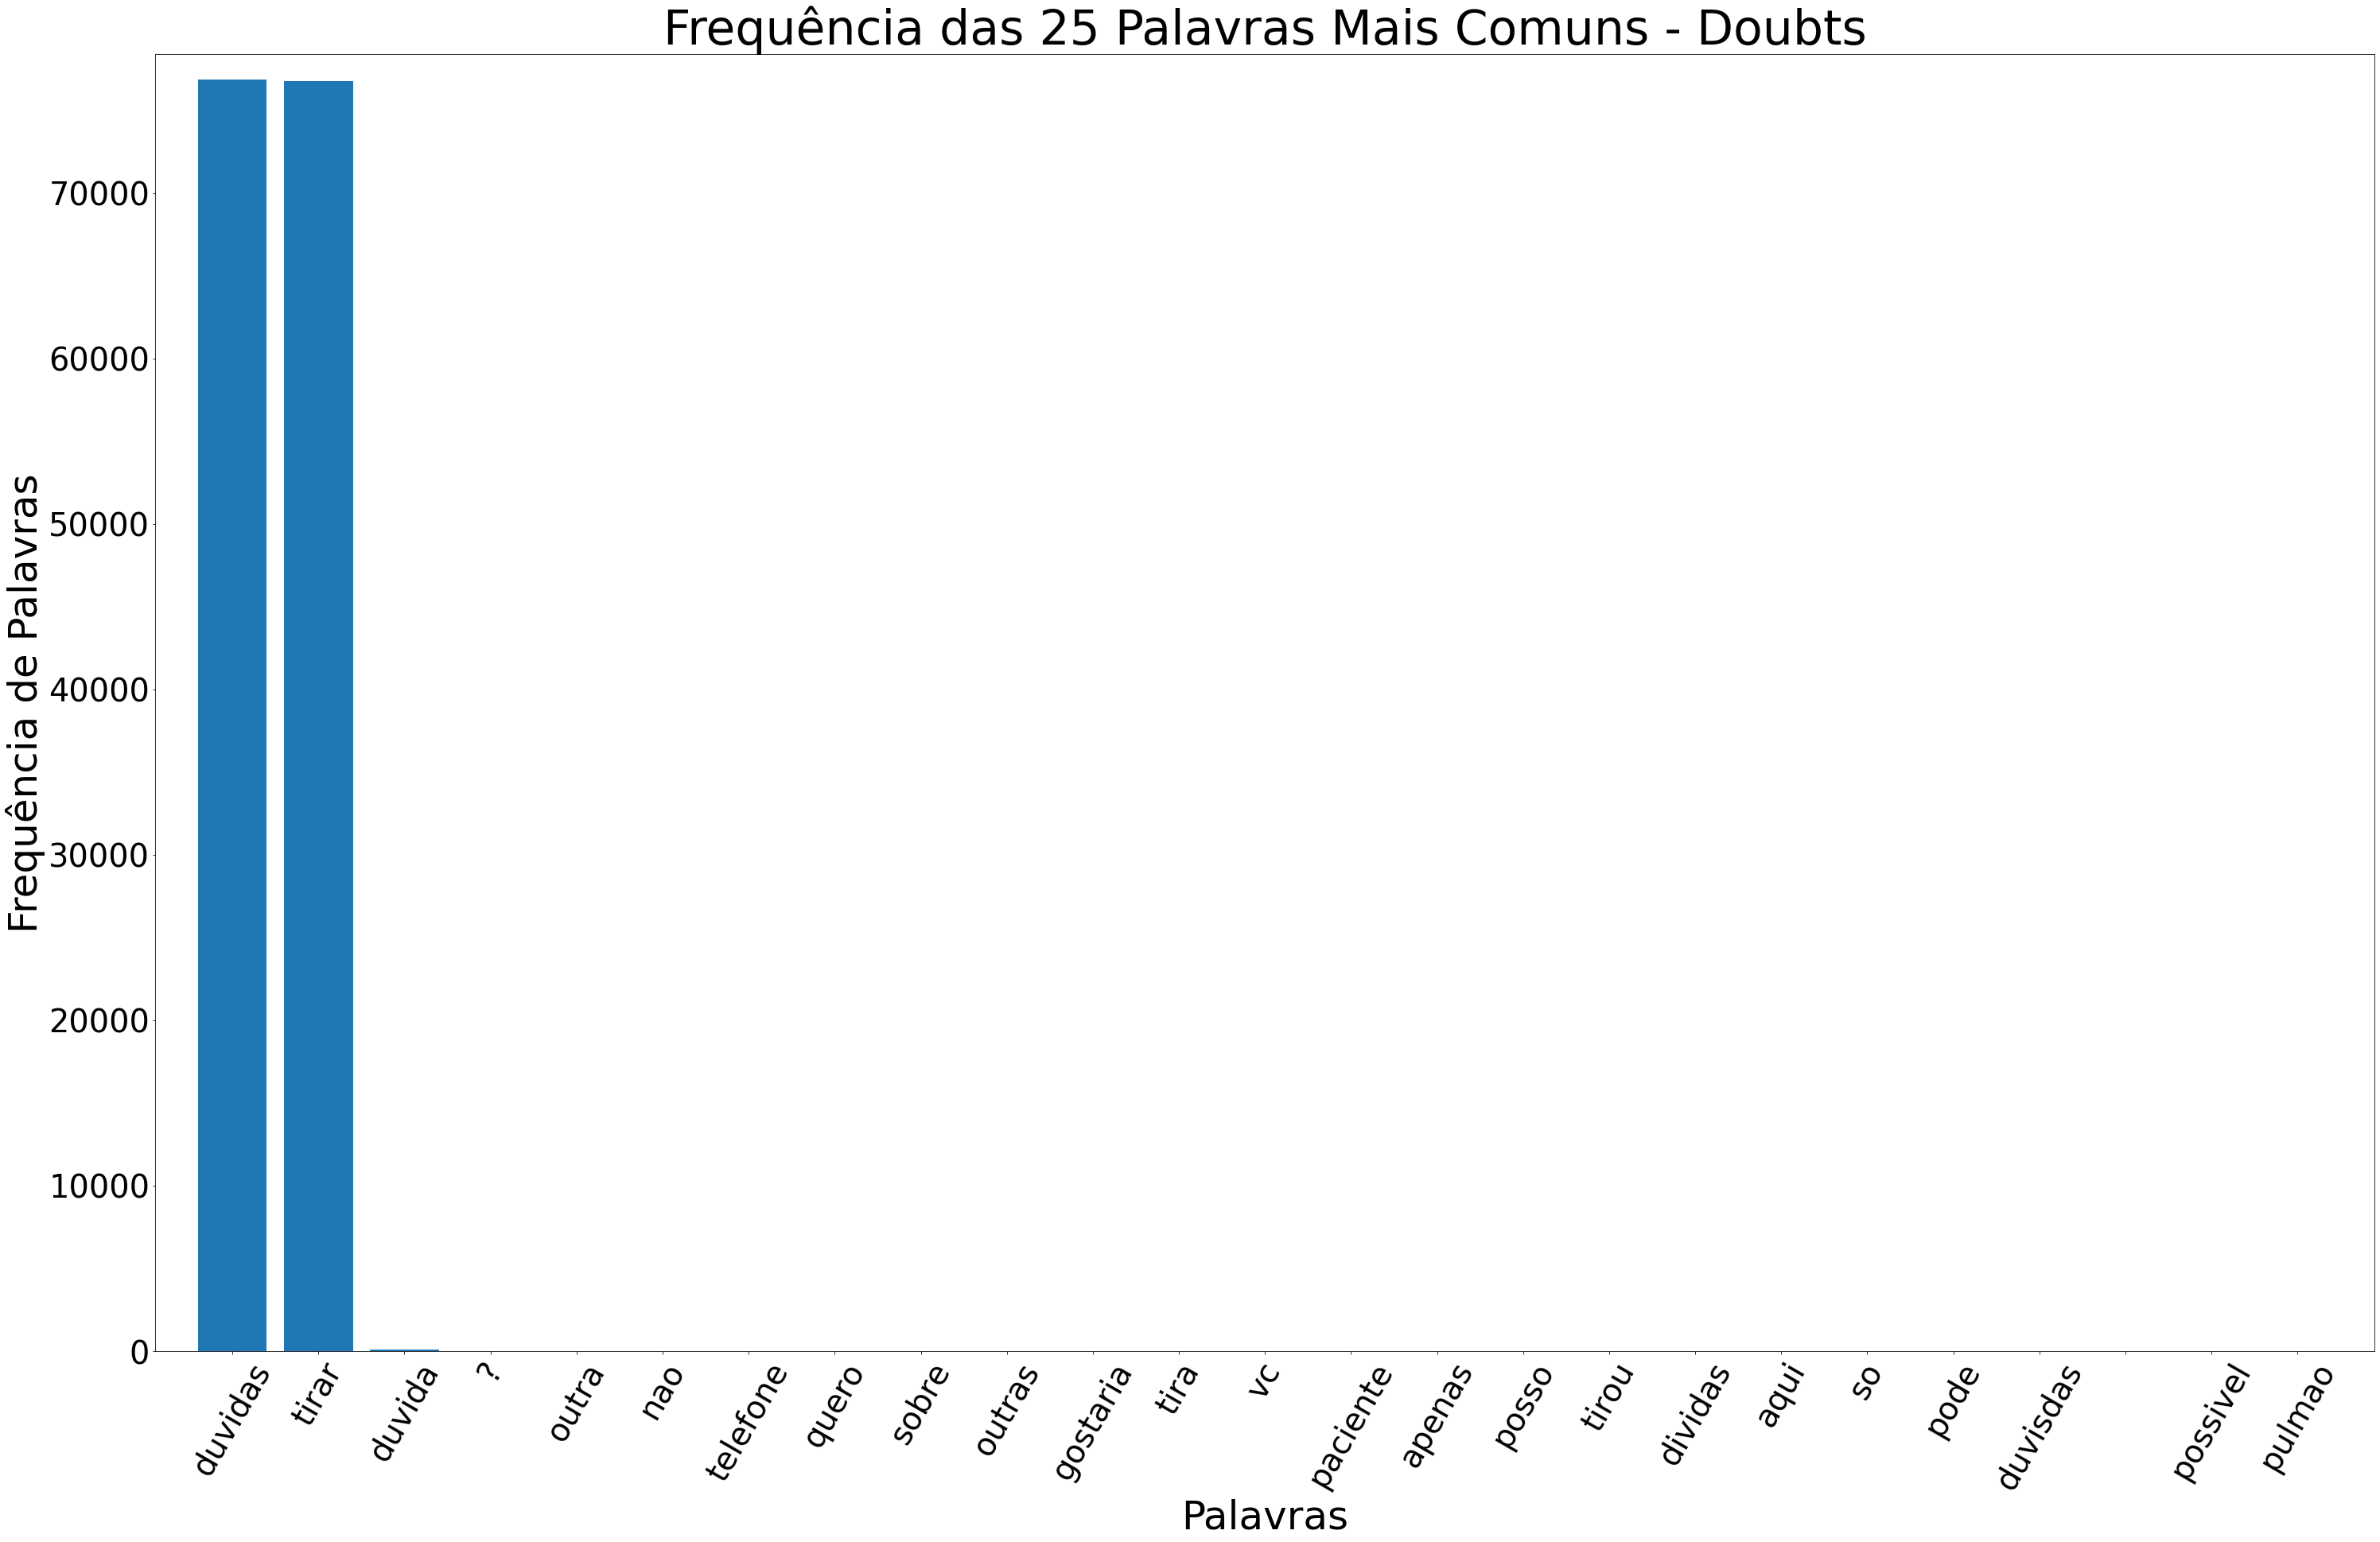

In [279]:
mostcommon_small_doubts = FreqDist(allwords_doubts).most_common(25)
x, y = zip(*mostcommon_small_doubts)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Palavras', fontsize=50)
plt.ylabel('Frequência de Palavras', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequência das 25 Palavras Mais Comuns - Doubts', fontsize=60)
plt.show()

## Doubts_Medical_Screening

In [280]:
words_doubts_ms = df_eda['stopwords_removed'][df_eda['intent']=='doubts_medical_screening']
allwords_doubts_ms = []
for wordlist in words_doubts_ms:
    allwords_doubts_ms += wordlist

allwords_doubts_ms = [x for x in allwords_doubts_ms if x not in lista_intents]

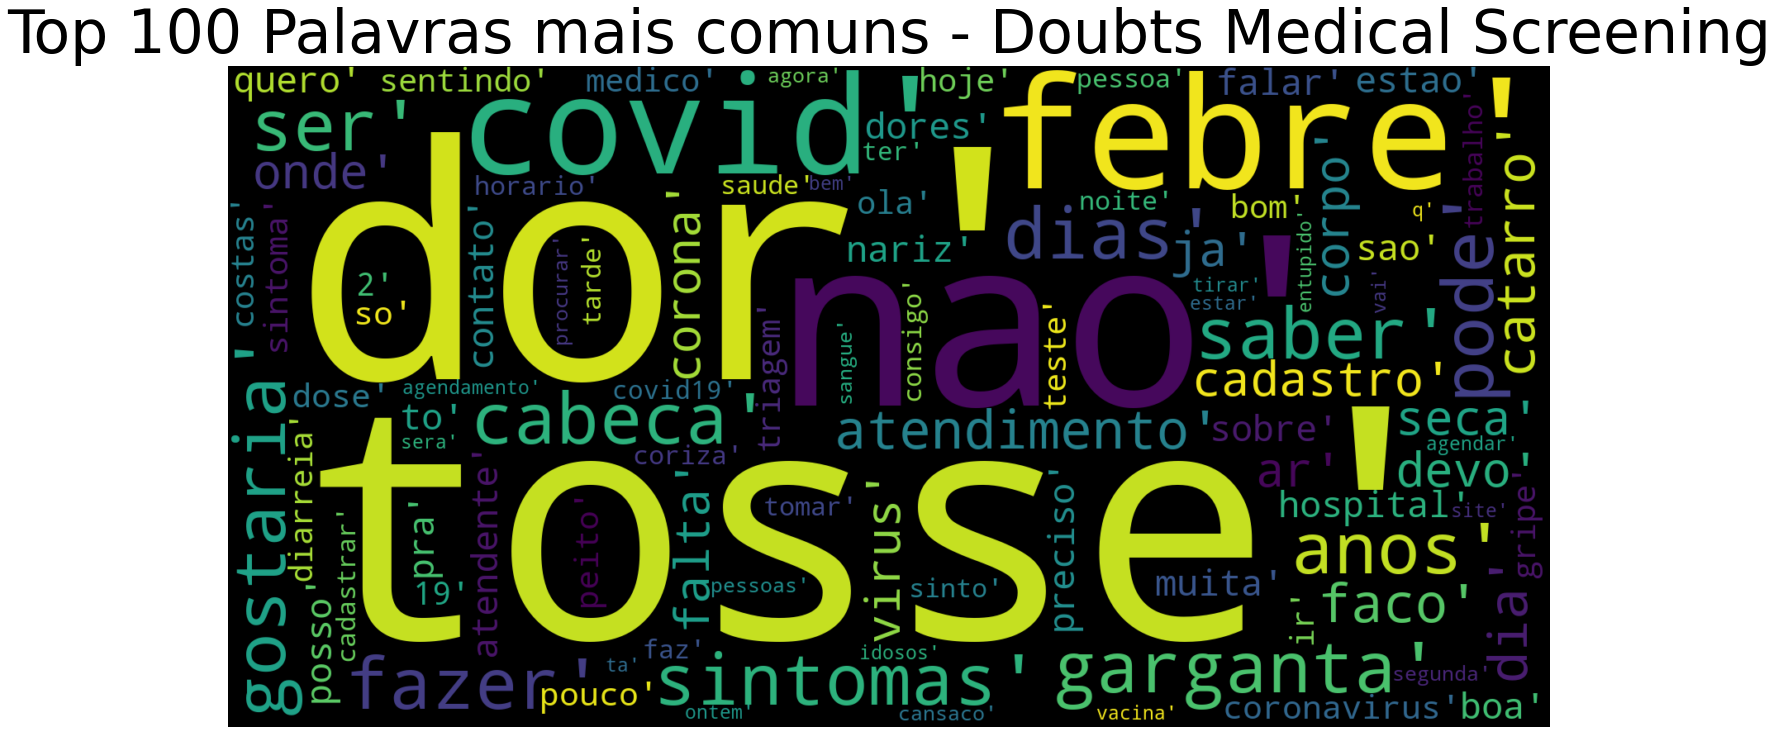

In [281]:
mostcommon_doubts_ms = FreqDist(allwords_doubts_ms).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='black', stopwords=lista_intents).generate(str(mostcommon_doubts_ms))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Palavras mais comuns - Doubts Medical Screening', fontsize=60)
plt.tight_layout(pad=0)
plt.show()

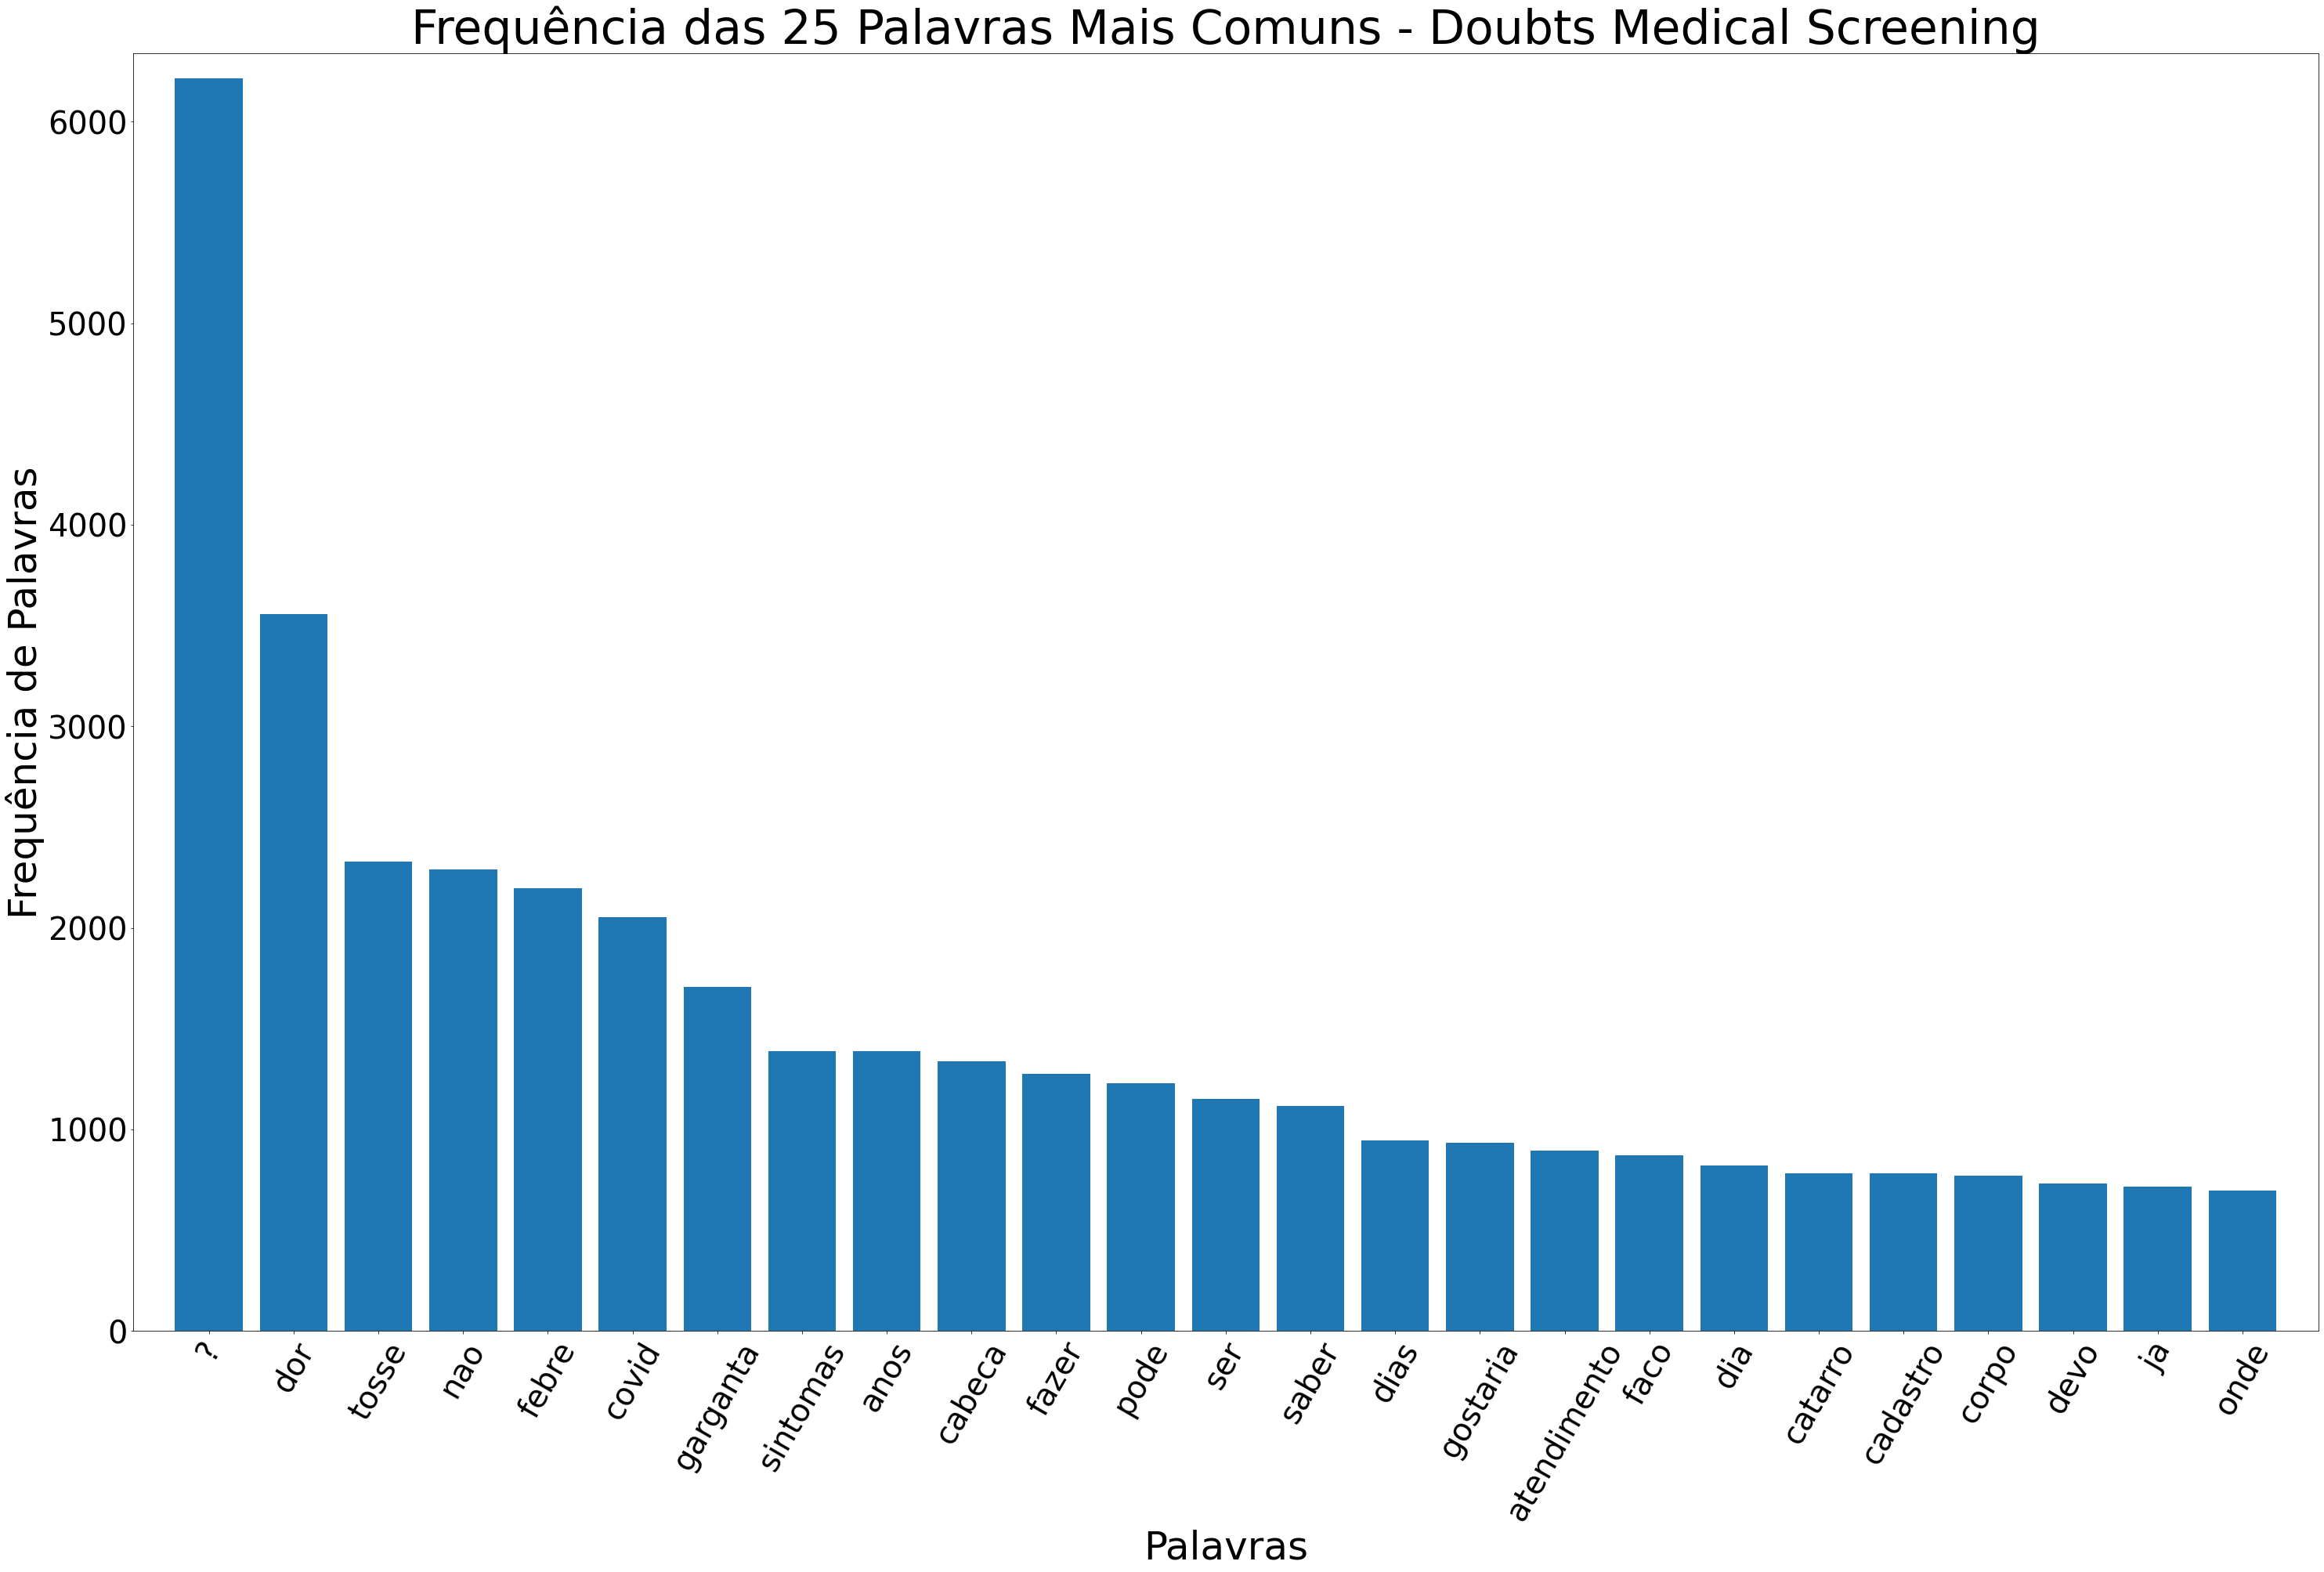

In [282]:
mostcommon_small_doubts_ms = FreqDist(allwords_doubts_ms).most_common(25)
x, y = zip(*mostcommon_small_doubts_ms)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Palavras', fontsize=50)
plt.ylabel('Frequência de Palavras', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequência das 25 Palavras Mais Comuns - Doubts Medical Screening', fontsize=60)
plt.show()

## Doubts_City_Hall

In [283]:
words_doubts_ch = df_eda['stopwords_removed'][df_eda['intent']=='doubts_city_hall']
allwords_doubts_ch = []
for wordlist in words_doubts_ch:
    allwords_doubts_ch += wordlist

allwords_doubts_ch = [x for x in allwords_doubts_ch if x not in lista_intents]

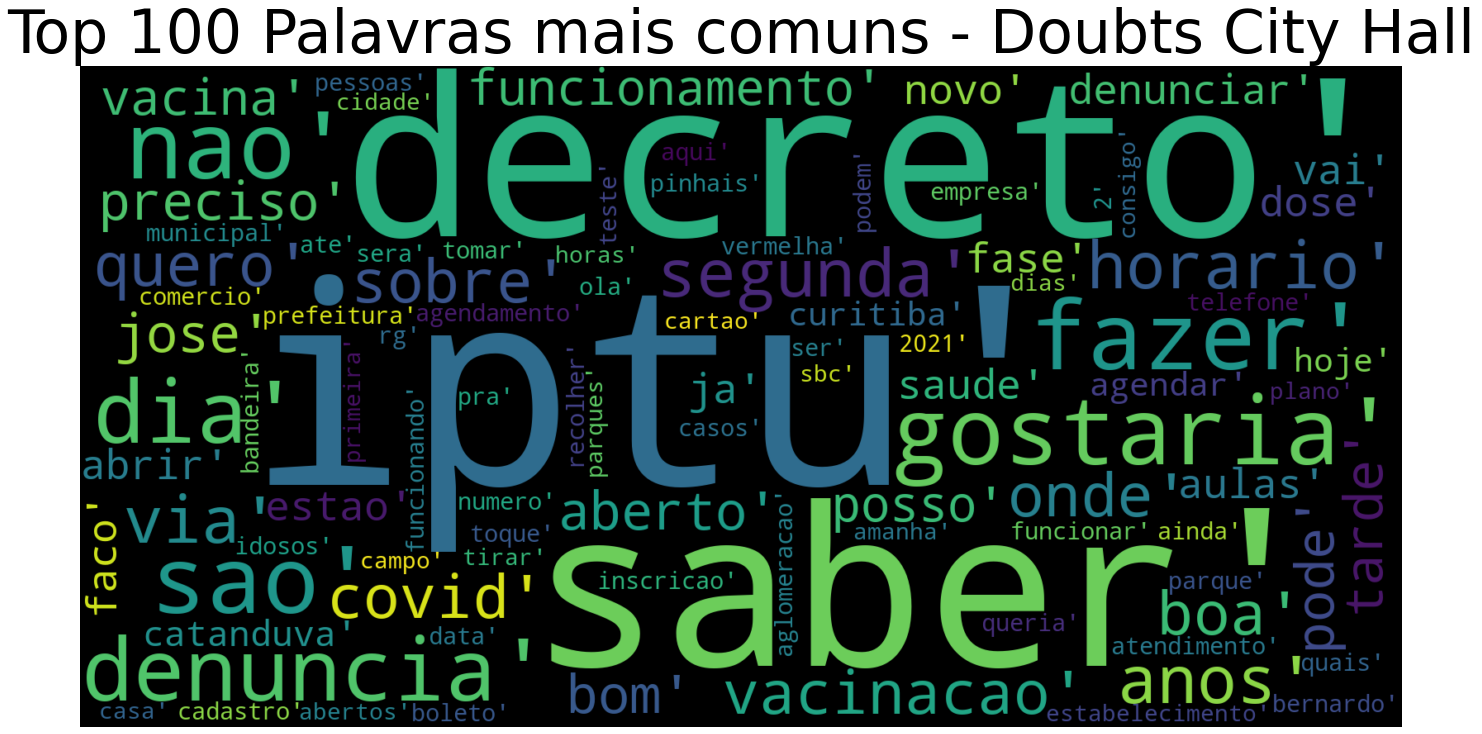

In [284]:
mostcommon_doubts_ch = FreqDist(allwords_doubts_ch).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='black', stopwords=lista_intents).generate(str(mostcommon_doubts_ch))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Palavras mais comuns - Doubts City Hall', fontsize=60)
plt.tight_layout(pad=0)
plt.show()

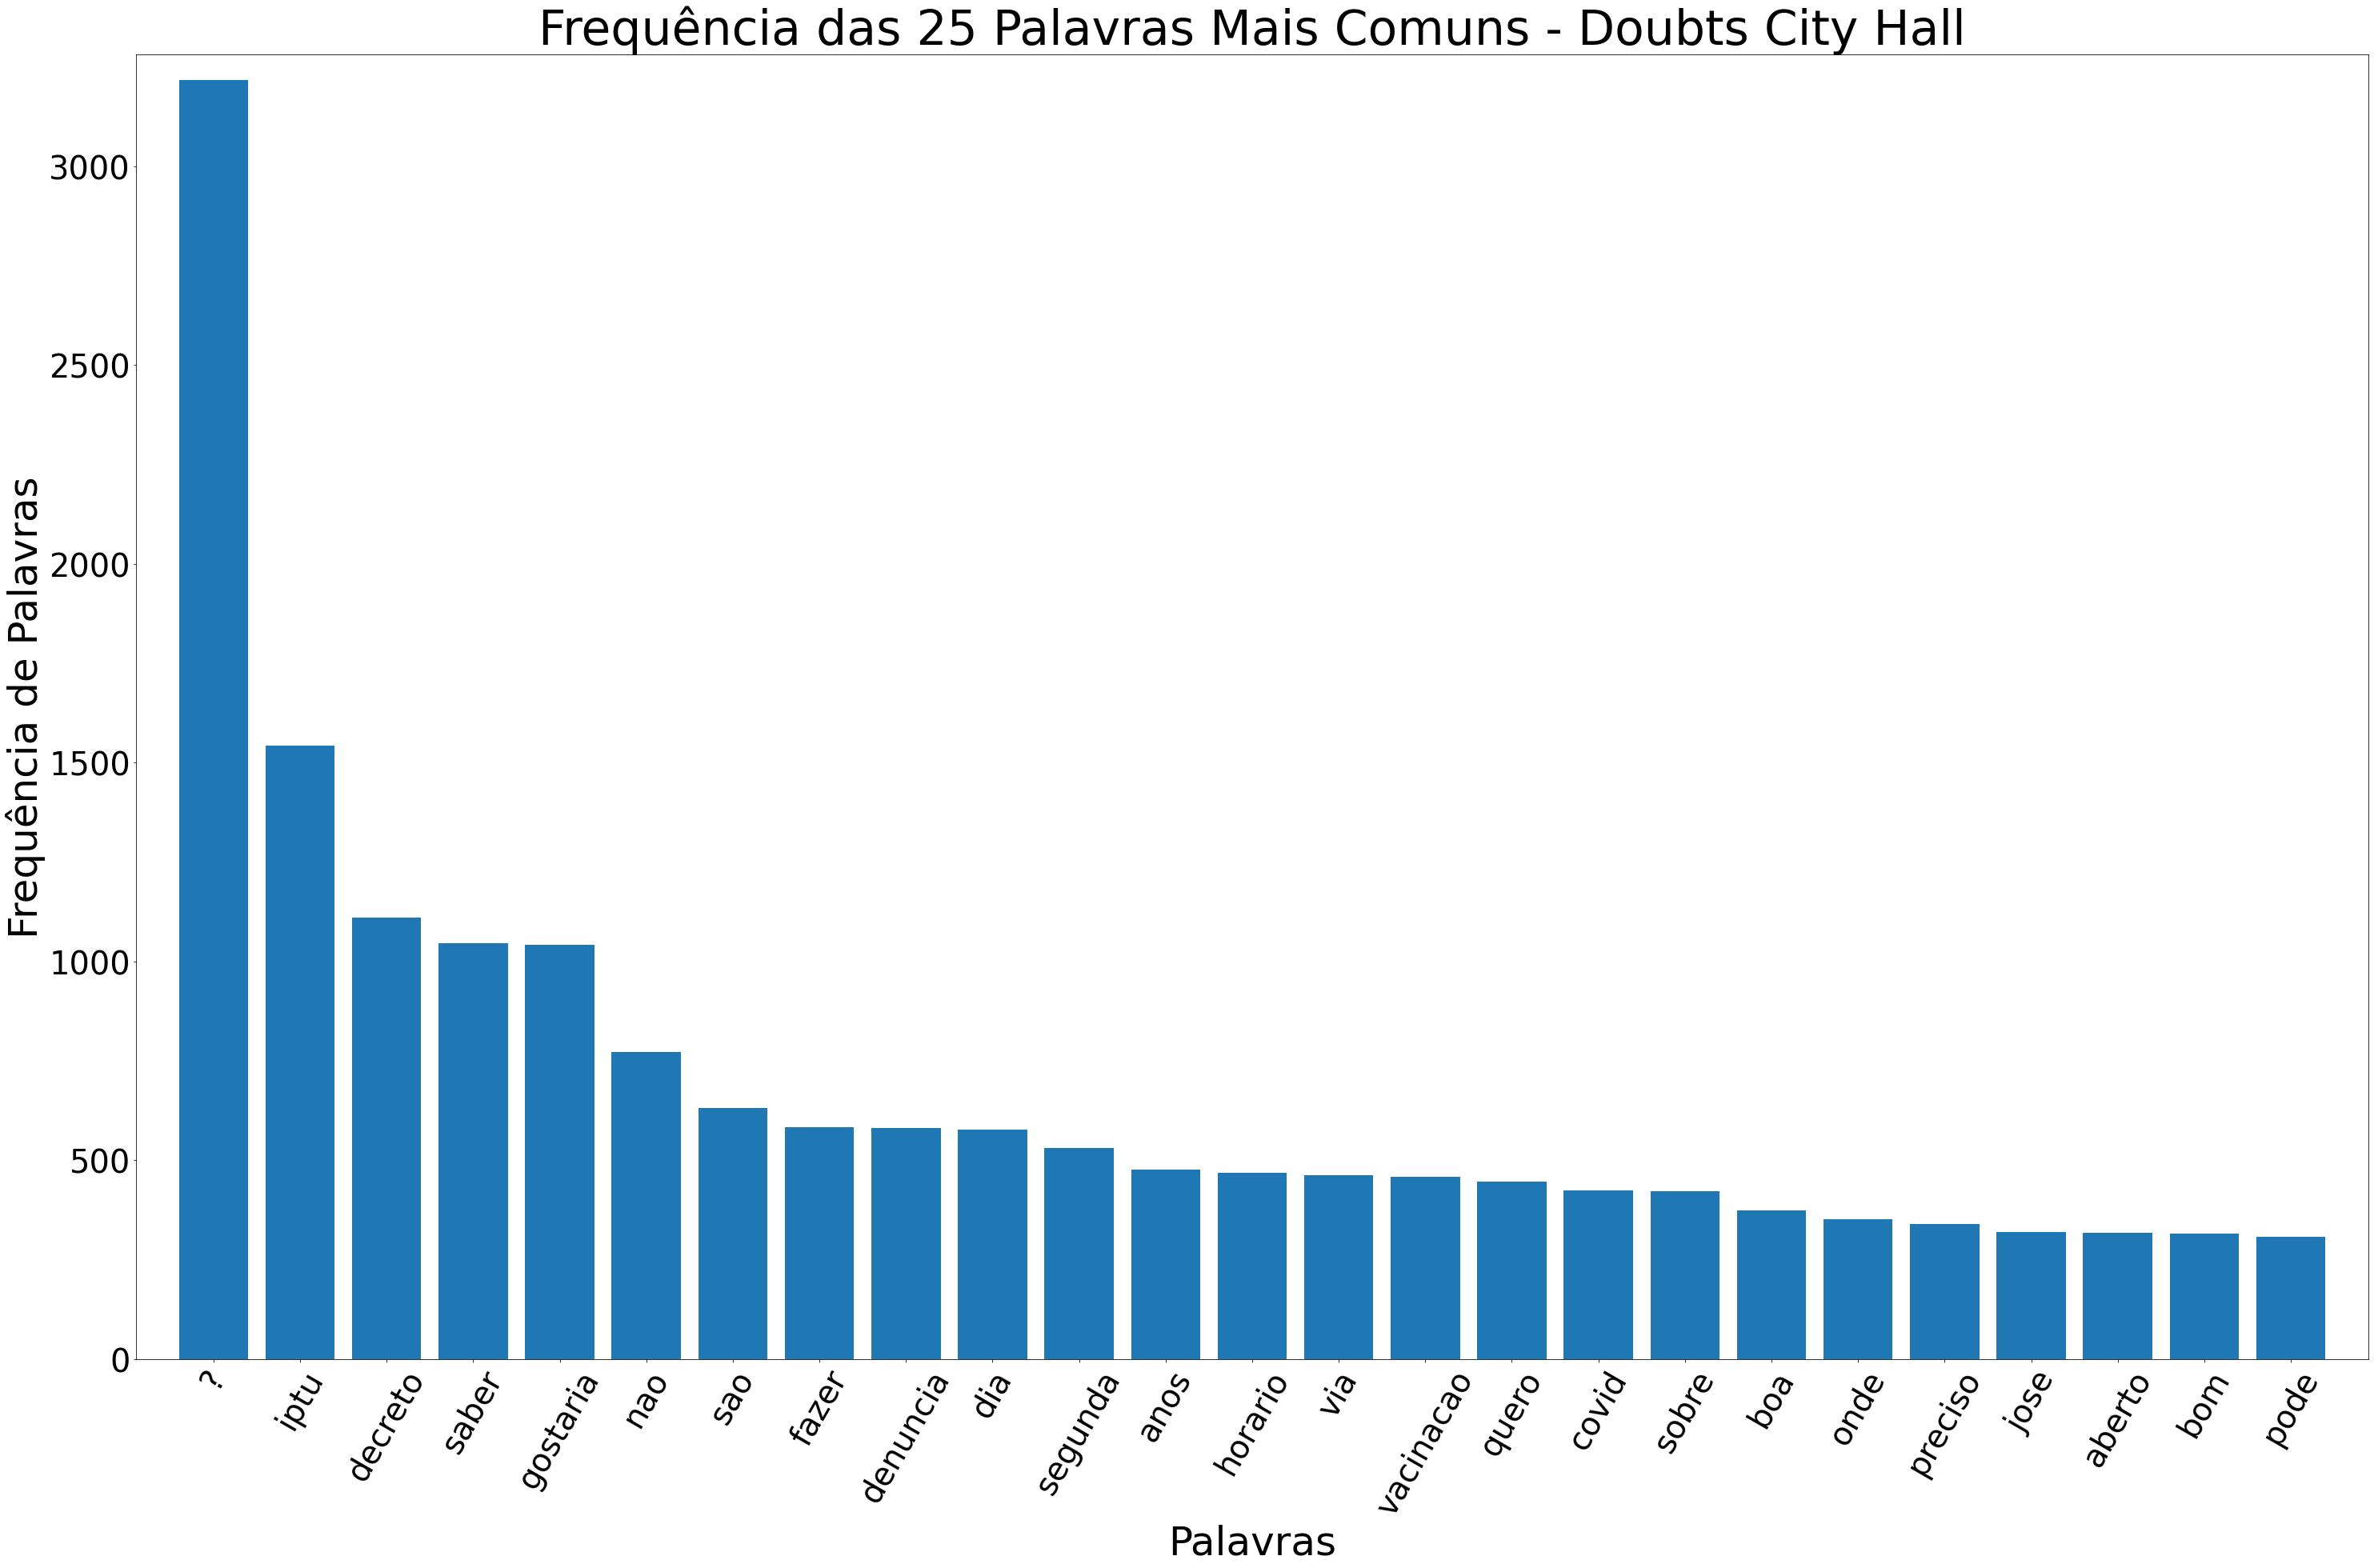

In [285]:
mostcommon_small_doubts_ch = FreqDist(allwords_doubts_ch).most_common(25)
x, y = zip(*mostcommon_small_doubts_ch)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Palavras', fontsize=50)
plt.ylabel('Frequência de Palavras', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequência das 25 Palavras Mais Comuns - Doubts City Hall', fontsize=60)
plt.show()

In [286]:
#checkpoint
df_eda.to_csv('dataset_eda.csv', header=True, index=False)

# Parte IV: Topic Modeling

Apesar de se tratar de um dataset anotado, a fonte classificadora de intenções foi um bot automatizado. Sendo assim, é interessante investigar, com os dados que temos a disposição, quais tópicos poderiam ser gerados através de outras análises. Aqui será testado o método Latent Dirichlet Allocation (LDA) para modelagem de tópicos.

Visando otimizar a eficiência do algoritmo, utilizaremos a coluna resultante do processo de stemming.

In [287]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)

In [288]:
tf = tf_vectorizer.fit_transform(df_eda['stemmed_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()

In [289]:
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

00  01  02  03  10  11  12  13  14  15  ...  viv  vo  voc  volt  \
0        0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
1        0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
2        0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
3        0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
4        0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ...   ...   
314626   0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
314627   0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
314628   0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
314629   0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   
314630   0   0   0   0   0   0   0   0   0   0  ...    0   0    0     0   

        vomit  vou  whatsapp  xarop  zon  zoolog  
0           0    0         0      0    0       0  
1           0    0         0      0    0       0  
2           0    0         0      0    0       0  
3           0    0         0      0    0       0  
4           0    0         0      0    0       0  
...       ...  ...       ...    ...  ...     ...  
314626      0    0         0      0    0       0  
314627      0    0         0      0    0       0  
314628      0    0         0      0    0       0  
314629      0    0         0      0    0       0  
314630      0    0         0      0    0       0  

[314631 rows x 1352 columns]

## Com os dados no formato adequado, usaremos o LDA para extração dos tópicos. Tentaremos elencar 5 tópicos principais, representados por 10 palavras cada:

In [290]:
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
covid exam nao ano result doubtsmedicalscreening doubtsmedicin dor menuprevention tom
Topic 1:
sintom sao qual doubtsvaccin doubtsvaccineord doubtscityhall ola cor viru doubtstestresult
Topic 2:
tir duvid doubtssymptom fatur titul rg reserv elei sextaf nf
Topic 3:
oi vacin sab vacinaca agend gost menutransmission pod quer atend
Topic 4:
test faz dia doubtsantibiotic boa cadastr menutreatment bom ond tard


### Em uma análise superficial, poderíamos separar os seguintes tópicos:

- Topic 0:
Dúvidas sobre exame/ assuntos médicos  
- Topic 1:
Dúvidas sobre sintomas
- Topic 2:
Dúvidas gerais/ prefeitura
- Topic 3:
Dúvidas dsobre vacinas
- Topic 4:
Dúvidas sobre testes